<a href="https://colab.research.google.com/github/MagnsW/PhD_Colab/blob/main/Basic_test_complete_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.model_selection import train_test_split

from keras.utils.vis_utils import plot_model

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# User Parameters

In [4]:
dataset_size = 10000
load_models = True # Loading previously saved model. Retraining models if false.
auto_scale = False # Whether or not to automatically scale the number of kernels to the number of outputs. If False, 2 convolutional kernels are used.

In [5]:
path = '/gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/'

# CNN Network 

In [6]:
def makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs):
  model = Sequential()
  model.add(Conv1D(no_kernels, length_kernel, activation='relu', padding='same', input_shape=input_shape))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(no_outputs, activation='linear'))
  return model

In [7]:
def plothistory(history):
  plt.figure(figsize=(16,10))
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('model mae')
  plt.ylabel('mae')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='upper right')
  plt.grid(which='both')
  plt.show()

In [8]:
def compile_and_train(X_train, y_train, filename, no_kernels=2,):
  length_kernel = 32
  no_outputs = y_train.shape[1]
  input_shape = (X_train.shape[1], X_train.shape[2]) # Only one trace per sample
  model = makecnnmodel(input_shape, no_kernels, length_kernel, no_outputs)
  print(model.summary())
  #plot_model(model, show_shapes=True, show_layer_names=True)
  model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
  history = model.fit(X_train, y_train, batch_size=20, epochs=100, verbose=1, validation_split=0.2, shuffle=True)
  plothistory(history)
  model.save(filename)
  return model


In [9]:
def getmodel(X_train, y_train, filename, loadmodel=False, autoscale=True):
  if loadmodel:
    model = load_model(filename)
    print('Model loaded: ' + filename)
  else:
    if autoscale:
      no_kernels = y_train.shape[1]
    else:
      no_kernels = 2
    model = compile_and_train(X_train, y_train, filename, no_kernels=no_kernels)
    

  return model

# Continous Wave

## Helper functions

In [10]:
def makecwsignal(amp, freq, phase, samplingfreq=128, t_end=1):
  # Returns CW cosine signal based on input parameters
  dt = 1/samplingfreq
  t_array = np.arange(0, t_end, dt)
  y = amp*np.cos(2*np.pi*freq*t_array + phase)
  return y

In [11]:
def makerandom(n, source_central_freq=10, source_mag = 1, seed=42):
  ''' Returns random frequencies around central frequency, random phase and 
  random amplitude. Random phase between 0 and pi.
  '''
  rng = np.random.default_rng(seed)
  randfreqs = source_central_freq*(0.5+rng.random(n))
  #randphases = 2*np.pi*rng.random(n) #if multiplied with 2, between 0 and 2pi
  randphases = rng.uniform(low=1, high=2*np.pi-1, size=n) #Phase between 1 and 5.28
  randamps = source_mag*(0.5+rng.random(n))
  d = {'Amplitude': randamps, 'Frequency': randfreqs, 'Phase': randphases}
  return pd.DataFrame(data=d)

In [12]:
def plot_hists(df):
  numplots = len(df.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(df.columns):
    plt.subplot(1,numplots, i+1)
    plt.hist(df[attribute])
    plt.title(attribute)

In [13]:
def preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  df_traces = pd.DataFrame(traces)
  plt.plot(traces[0])
  plt.plot(traces[1])
  plt.show()
  plt.figure(figsize=(18, 10))
  plt.pcolormesh(df_traces.T)
  plt.gca().invert_yaxis()
  plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(df_traces, df_iterations, test_size=0.2, random_state=42)
  X_train = np.expand_dims(X_train, axis=2)
  X_train.shape, y_train.shape
  return X_train, X_test, y_train, y_test

### Prediction

In [14]:
def test_and_predict(model, X_test, y_test):
  if X_test.ndim < 3:
    X_test = np.expand_dims(X_test, axis=2)
  model.evaluate(X_test, y_test)
  y_predict = model(X_test)
  df_y_predict = pd.DataFrame(y_predict.numpy(), columns=y_test.columns)
  return df_y_predict


In [15]:
def plotprediction(data_truth, data_prediction):
  numplots = len(data_prediction.columns)
  plt.figure(figsize=(6*numplots,8))
  
  for i, attribute in enumerate(data_prediction.columns):
    plt.subplot(1,numplots, i+1)
    plt.scatter(data_truth[attribute], data_prediction[attribute])
    plt.plot([min(data_truth[attribute]), max(data_truth[attribute])], [min(data_truth[attribute]), max(data_truth[attribute])], 'r--' )
    plt.title('Predicted vs true ' + attribute)
    plt.grid(which='both')
  plt.show()

## Main section

In [16]:
df_iterations = makerandom(dataset_size)

In [17]:
traces_clean = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

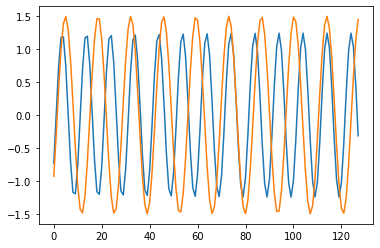

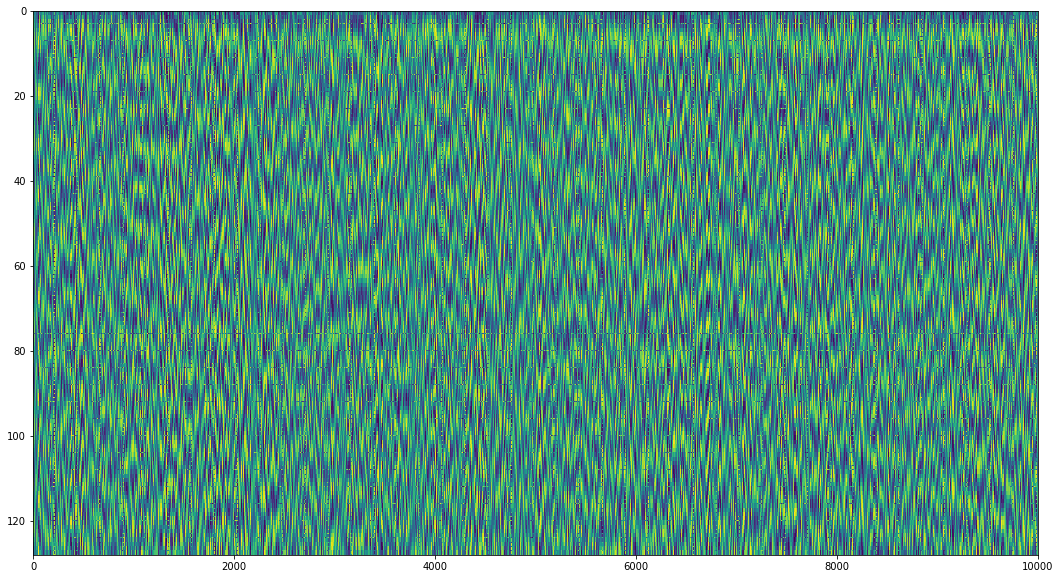

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 128, 2)            66        
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

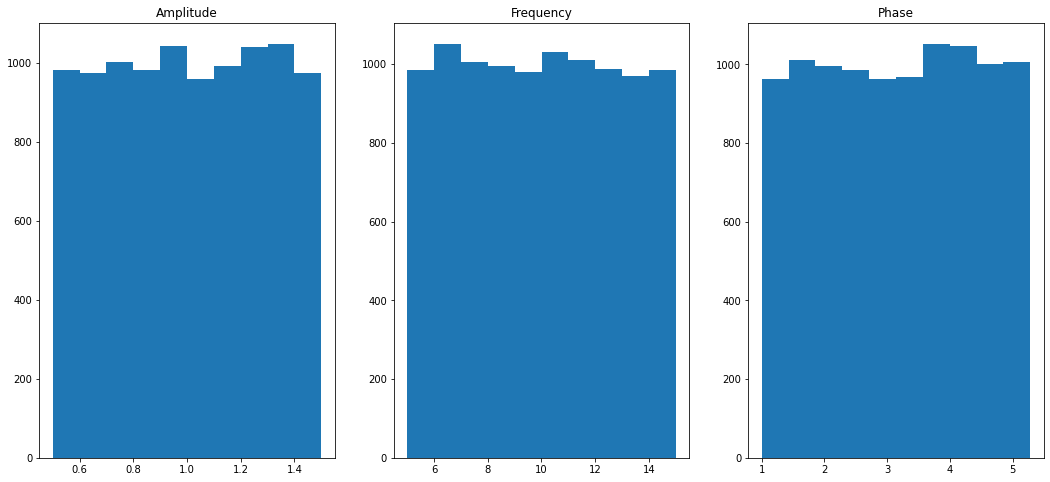

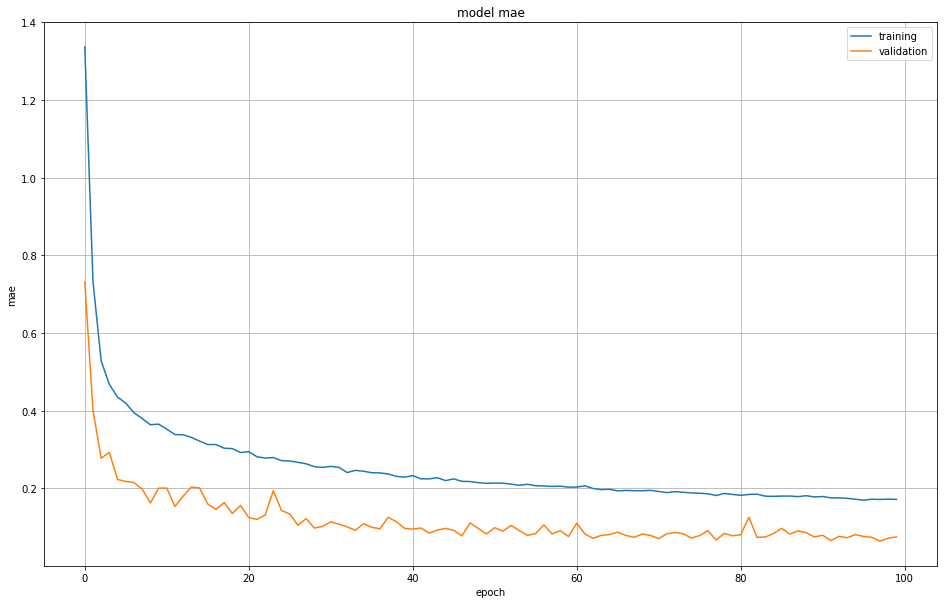

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_cw_clean/assets


In [18]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=False)
model_cw_clean = getmodel(X_train, y_train, filename=path+'model_cw_clean', loadmodel=load_models, autoscale=auto_scale)

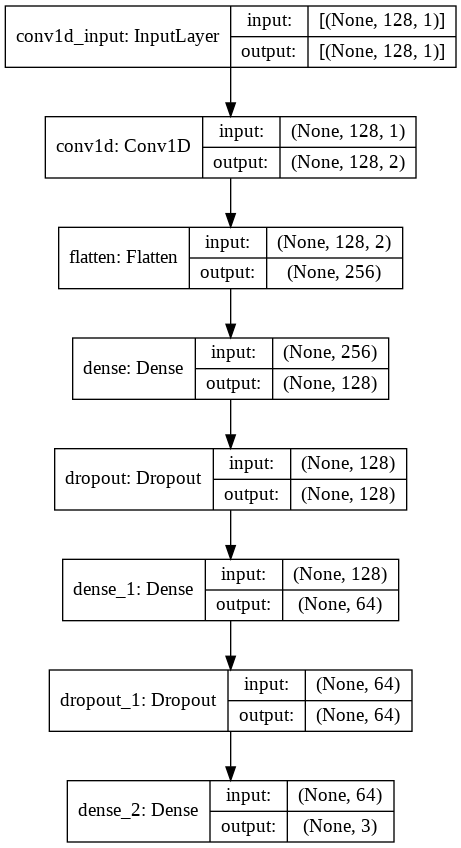

In [19]:
plot_model(model_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0124 - mse: 0.0124 - mae: 0.0752


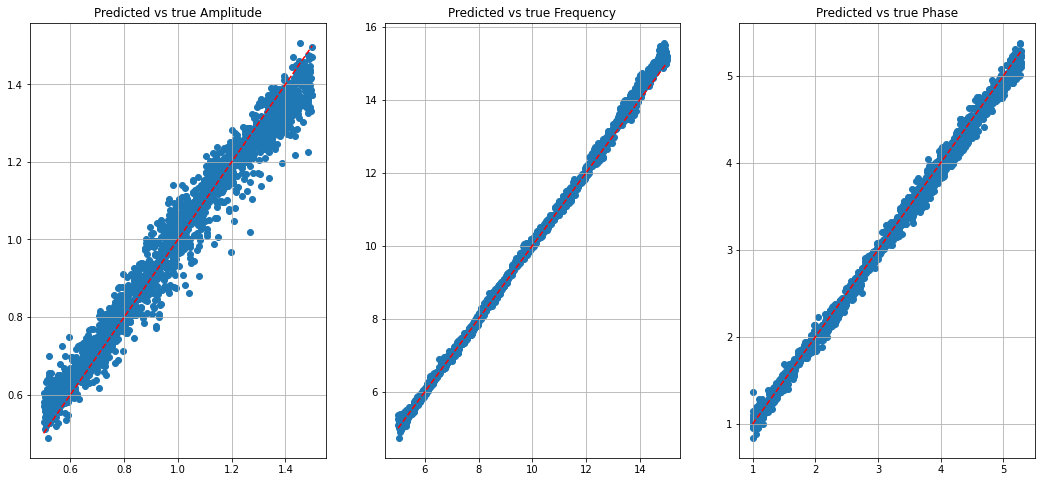

In [20]:
df_y_predict = test_and_predict(model_cw_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

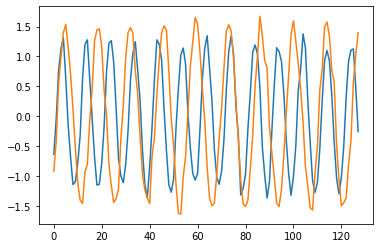

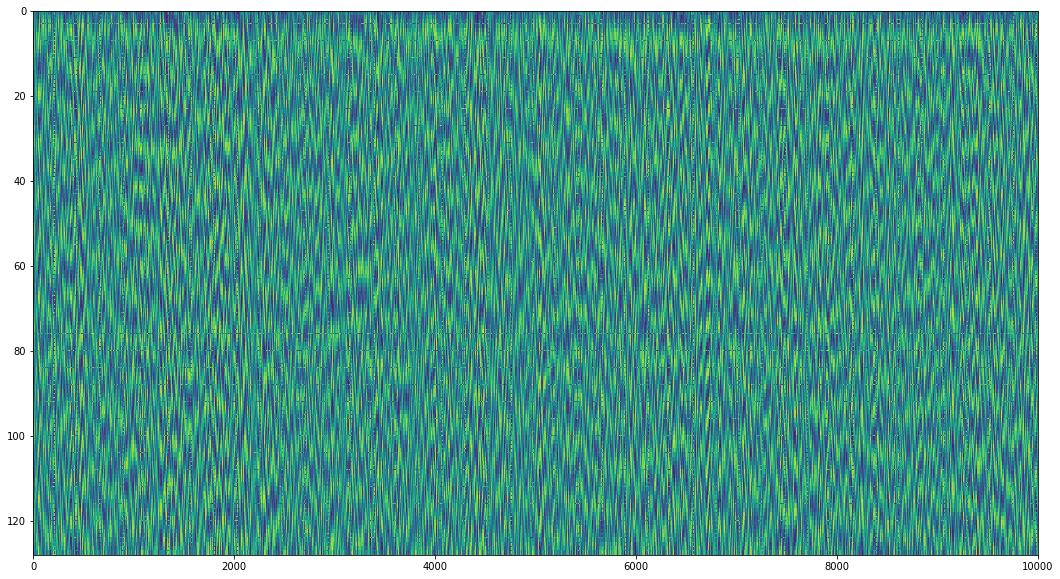

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

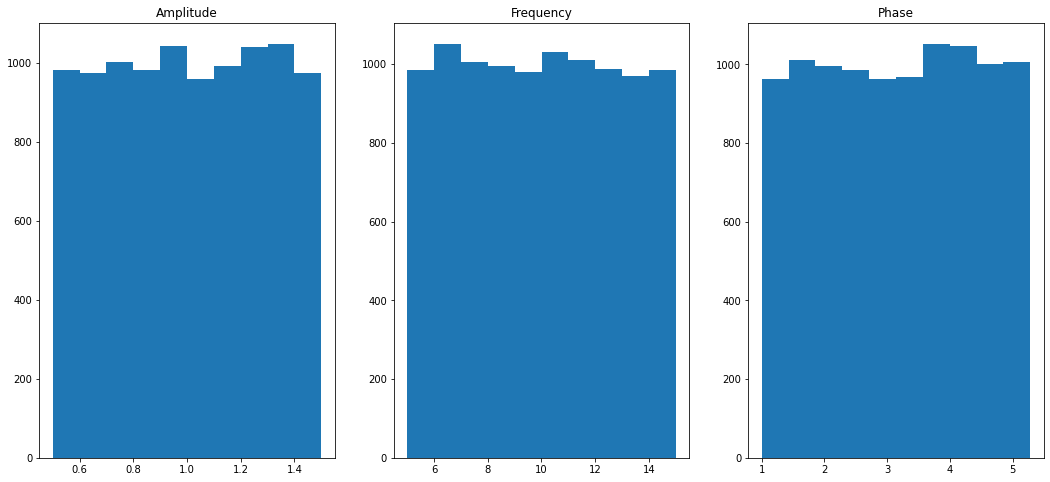

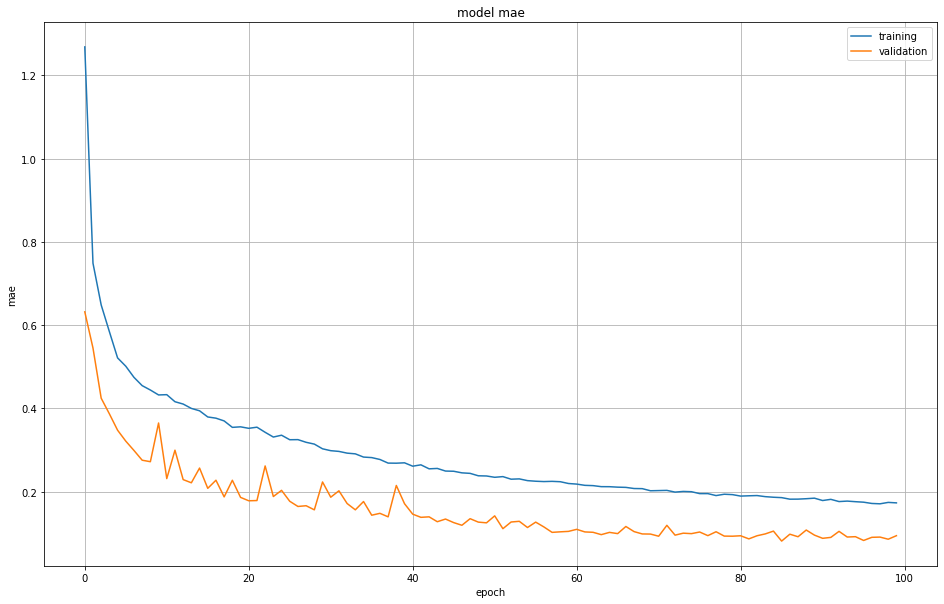

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_cw_noisy/assets


In [21]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(traces_clean, df_iterations, noiseon=True)
model_cw_noisy = getmodel(X_train, y_train, filename=path+'model_cw_noisy', loadmodel=load_models, autoscale=auto_scale)

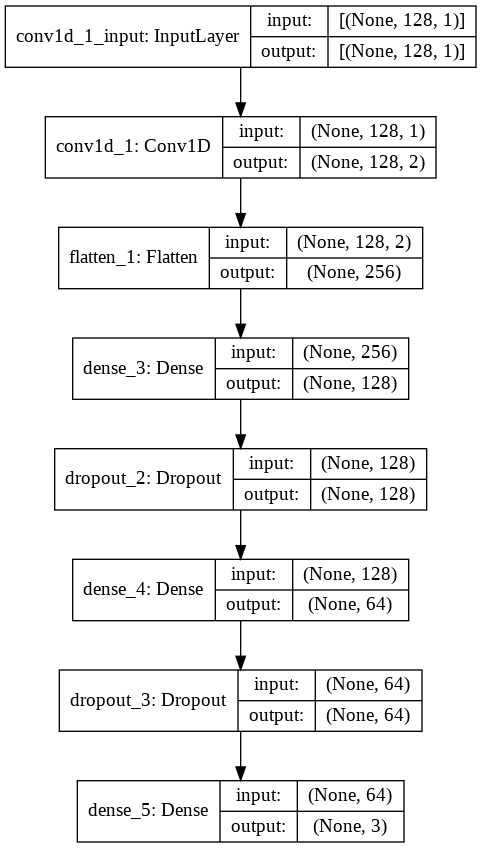

In [22]:
plot_model(model_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 0.0168 - mse: 0.0168 - mae: 0.0948


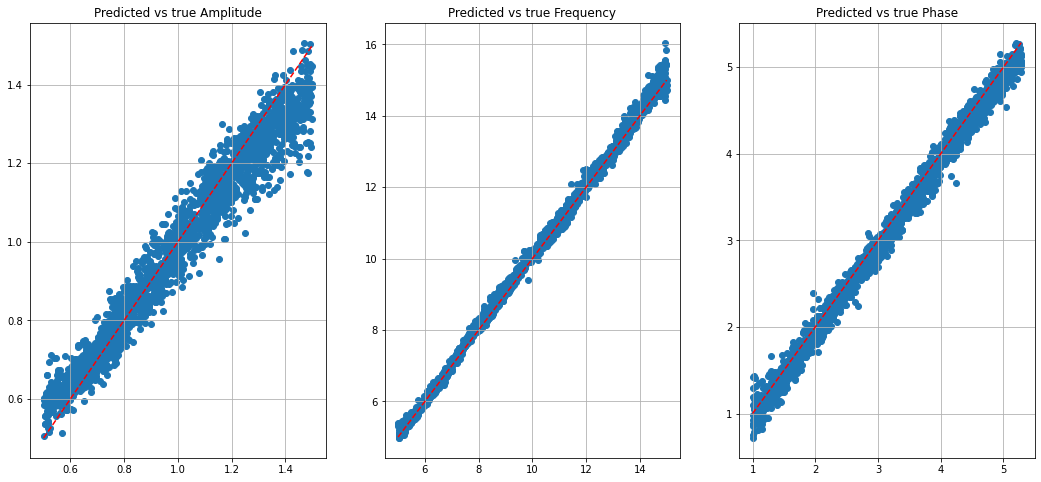

In [23]:
df_y_predict = test_and_predict(model_cw_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Signal Pulse

## Helper functions

In [24]:
from scipy import signal
from scipy.fft import fft, fftshift

In [25]:
def makepulse(amp, freq, phase, samplingfreq=128, std=9, t_end=1):
  dt = 1/samplingfreq
  #t_end = samples*dt
  samples = t_end/dt
  t_array = np.arange(0, t_end, dt)
  window = signal.windows.gaussian(samples, std)
  y = amp*np.cos(2*np.pi*freq*t_array + phase) * window
  return y

## Main section

In [26]:
pulse_traces_clean = [makepulse(row[0], row[1], row[2]) for row in zip(df_iterations['Amplitude'], df_iterations['Frequency'], df_iterations['Phase'])]

### Clean

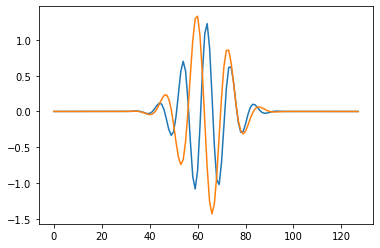

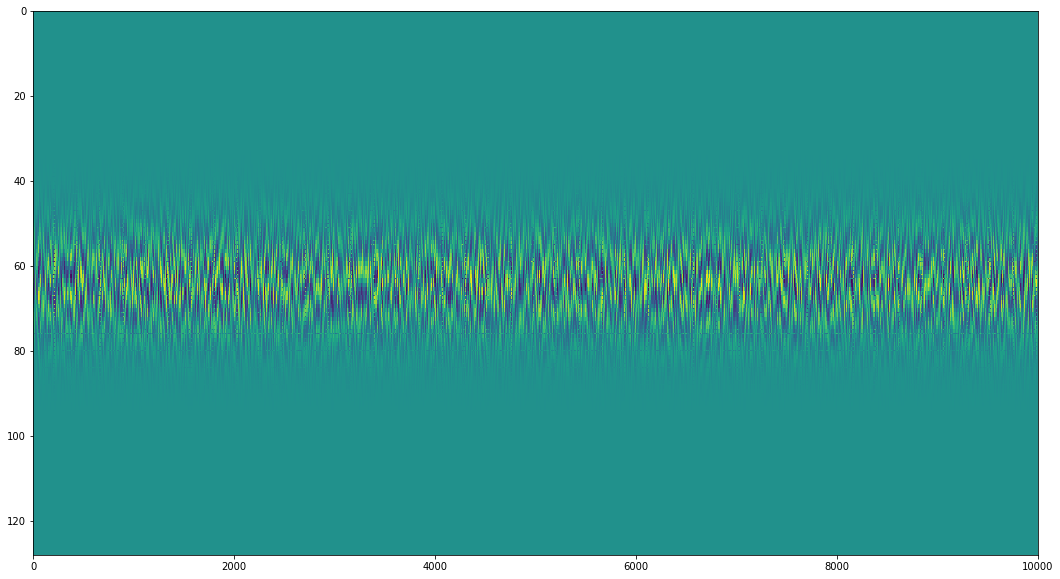

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                

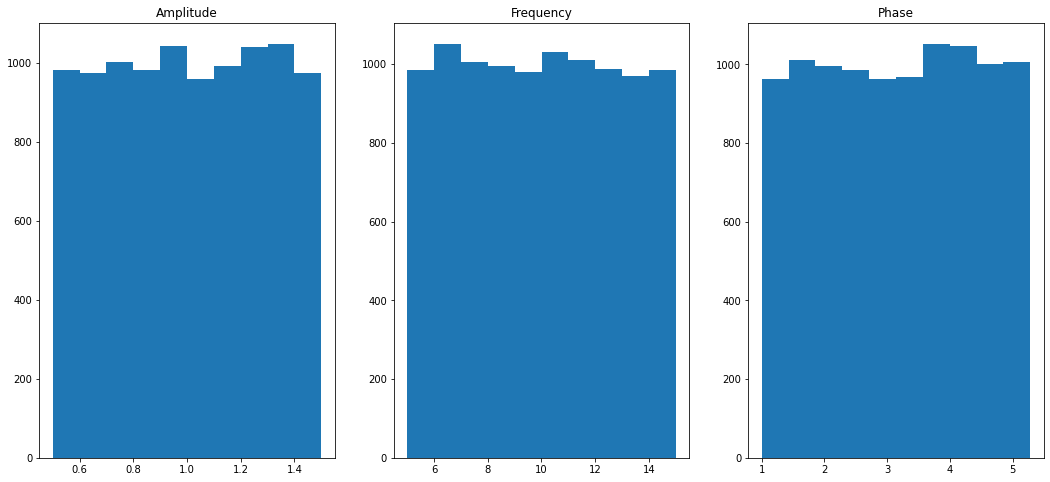

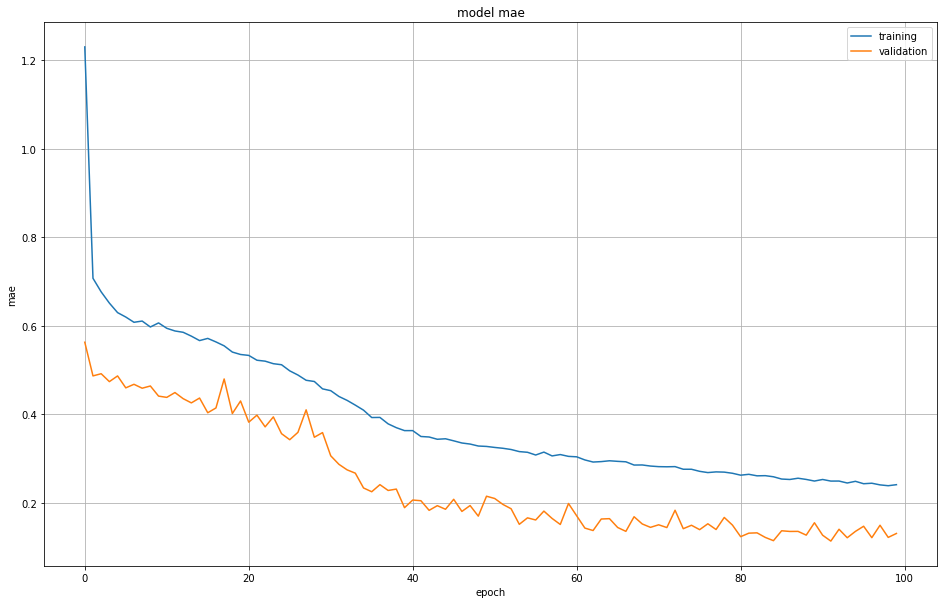

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_clean/assets


In [27]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=False)
model_pulse_clean = getmodel(X_train, y_train, filename=path+'model_pulse_clean', loadmodel=load_models, autoscale=auto_scale)

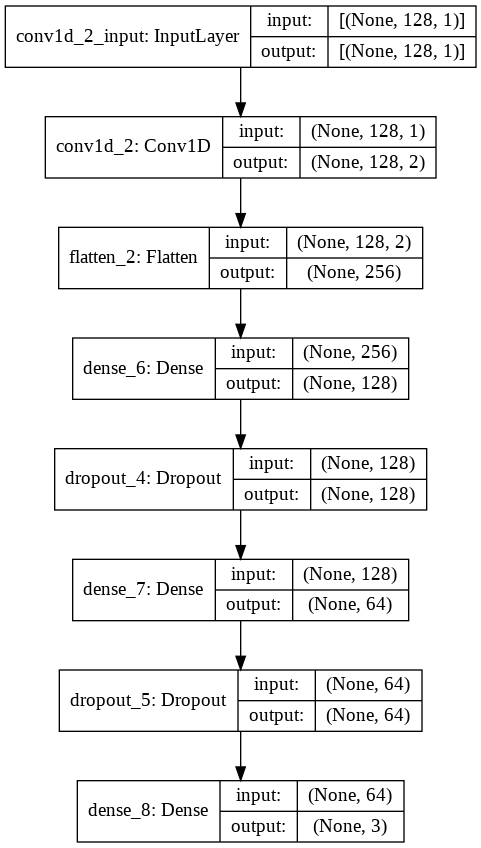

In [28]:
plot_model(model_pulse_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1305


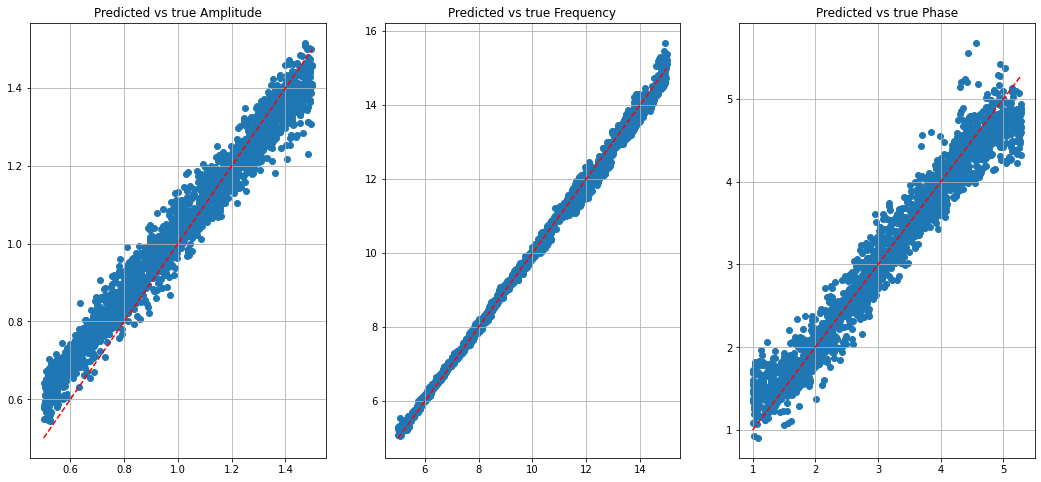

In [29]:
df_y_predict = test_and_predict(model_pulse_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

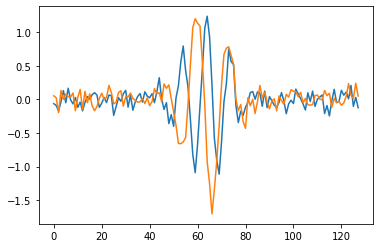

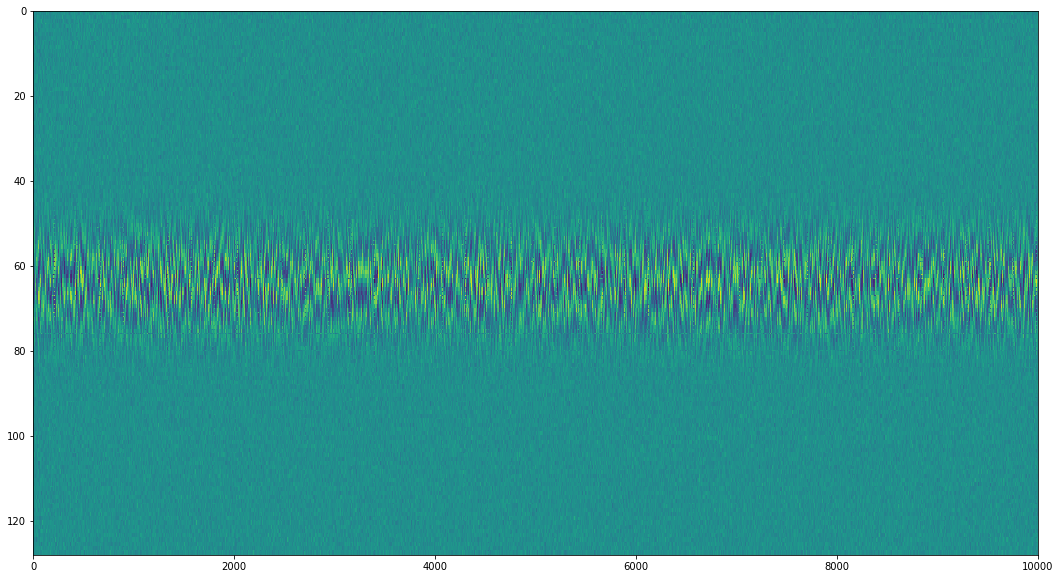

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                

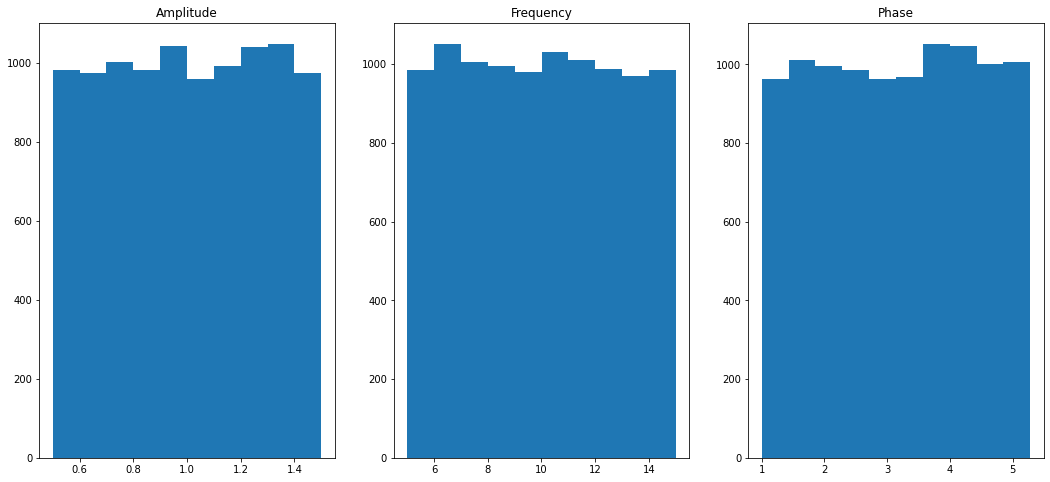

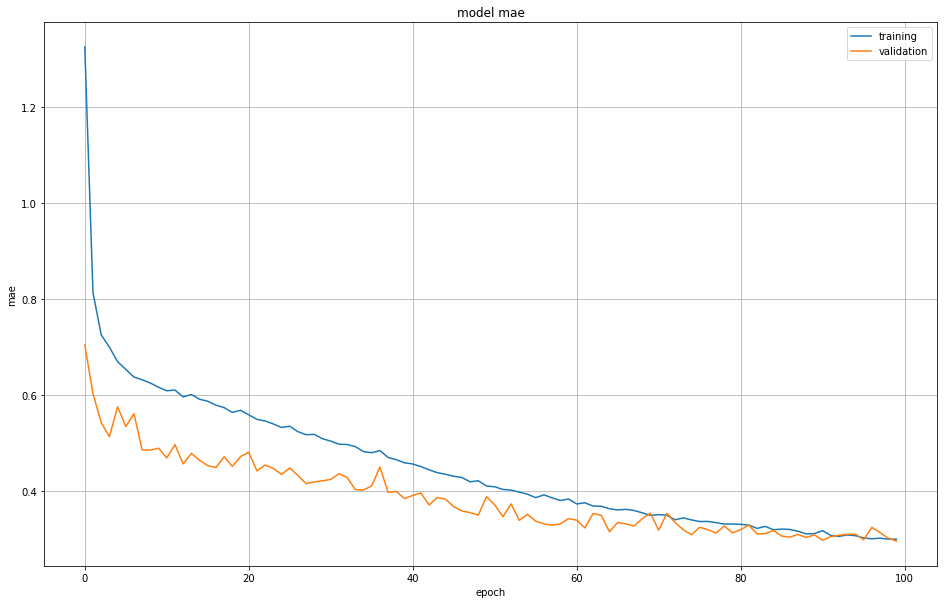

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_noisy/assets


In [30]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_traces_clean, df_iterations, noiseon=True)
model_pulse_noisy = getmodel(X_train, y_train, filename=path+'model_pulse_noisy', loadmodel=load_models, autoscale=auto_scale)

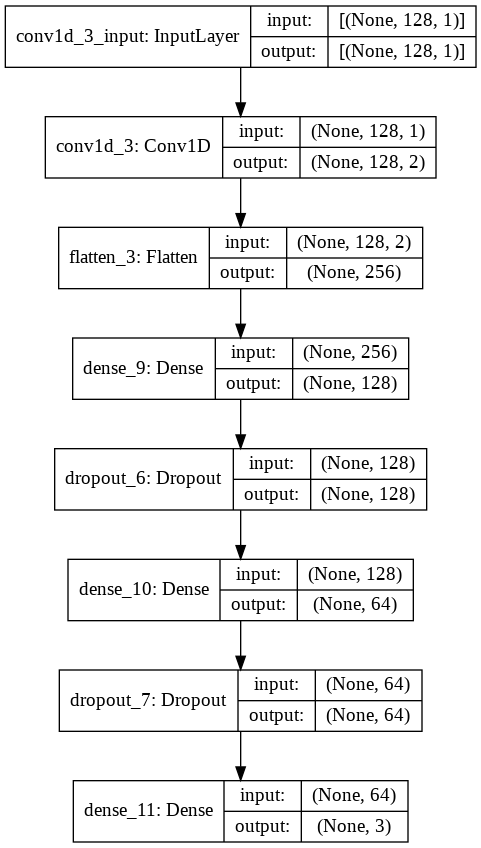

In [31]:
plot_model(model_pulse_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.2411 - mse: 0.2411 - mae: 0.2956


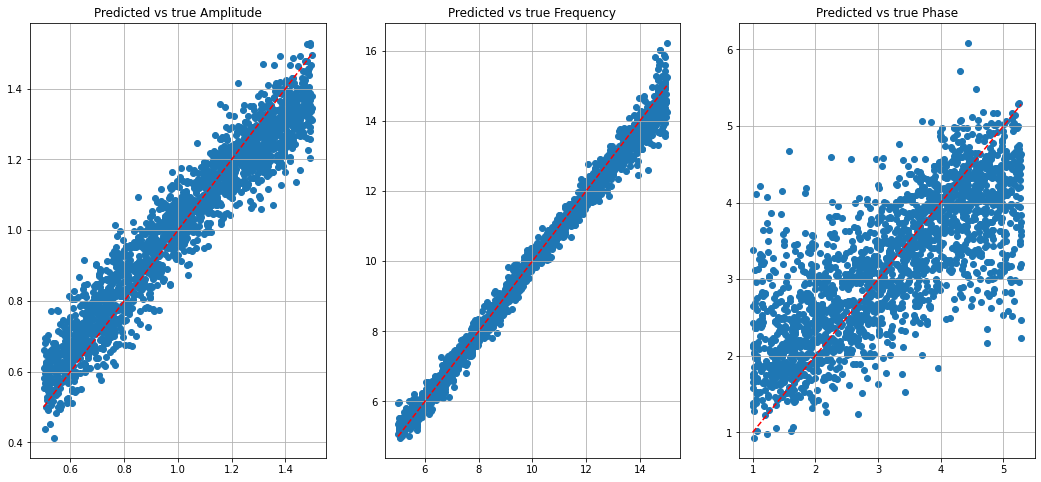

In [32]:
df_y_predict = test_and_predict(model_pulse_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Pulse with timeshift


## Helper functions

In [33]:
def makepulsetimes(pulse, times, samplingfreq=128, t_end=1):
  dt = 1/samplingfreq
  samples = samplingfreq*t_end
  t_array = np.arange(0, t_end, dt)
  events = np.zeros(samples)
  #print(type(times))
  if type(times) is list:
    #print('this is a list')
    idx = [int(x / dt) for x in times]
  else: 
    idx = int(times / dt)
  events[idx] = 1
  filtered = signal.convolve(events, pulse, mode='same')
  return filtered

In [34]:
def makerandomtimeshift(n, min, max, seed=42):
  rng = np.random.default_rng(seed)
  times = rng.uniform(low=min, high=max, size=n)
  d = {'Timeshift': times}
  return pd.DataFrame(data=d)

## Main section

In [35]:
df_iterations_timeshifts = makerandomtimeshift(len(df_iterations), 0.1, 0.9)
df_iterations_w_timeshifts = df_iterations.join(df_iterations_timeshifts)

In [36]:
pulse_timeshift_traces_clean = [makepulsetimes(row[0], row[1]) for row in zip(pulse_traces_clean, df_iterations_w_timeshifts['Timeshift'])]

### Clean

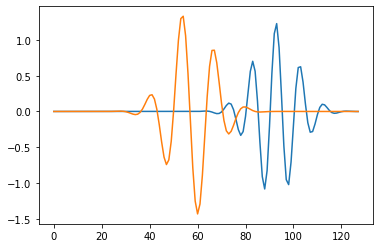

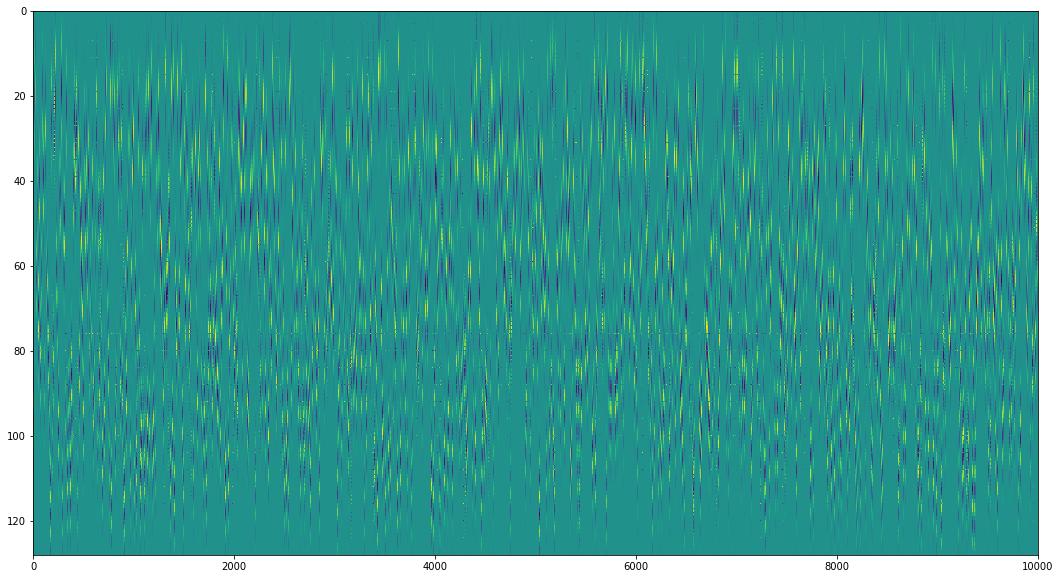

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                

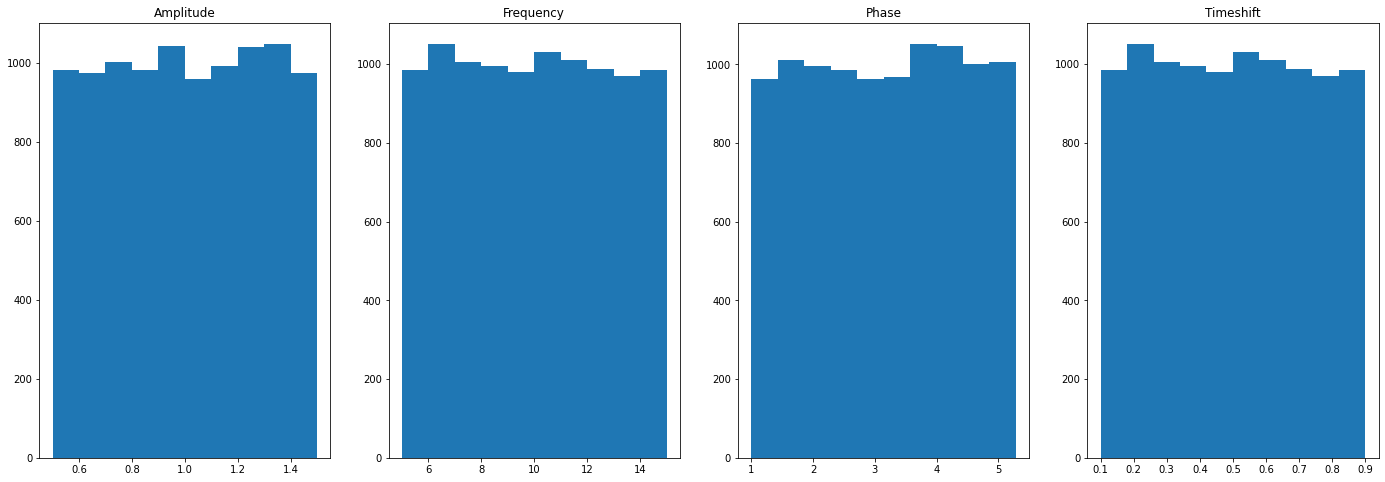

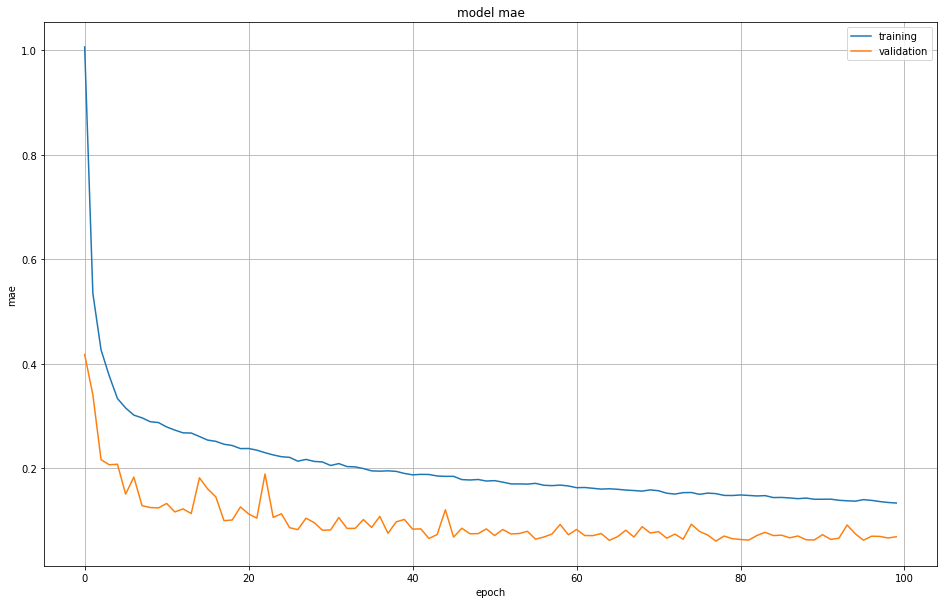

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_timeshift_clean/assets


In [37]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=False)
model_pulse_timeshift_clean = getmodel(X_train, y_train, filename=path+'model_pulse_timeshift_clean', loadmodel=load_models, autoscale=auto_scale)

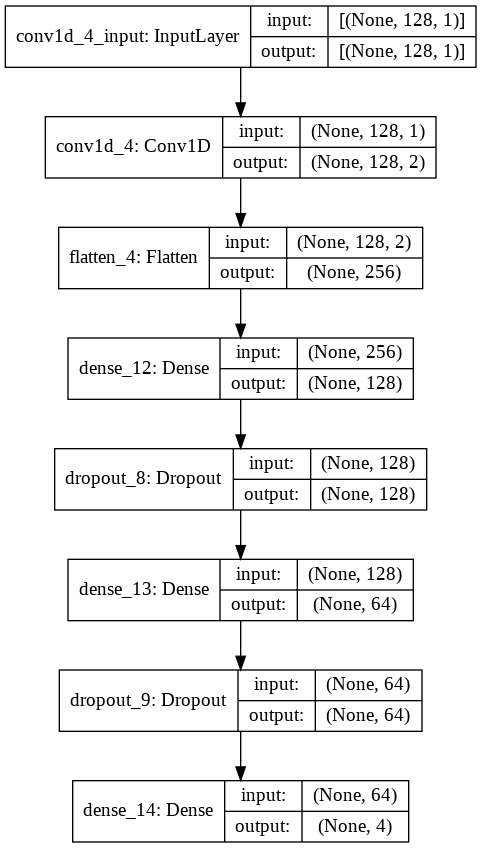

In [38]:
plot_model(model_pulse_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0100 - mse: 0.0100 - mae: 0.0676


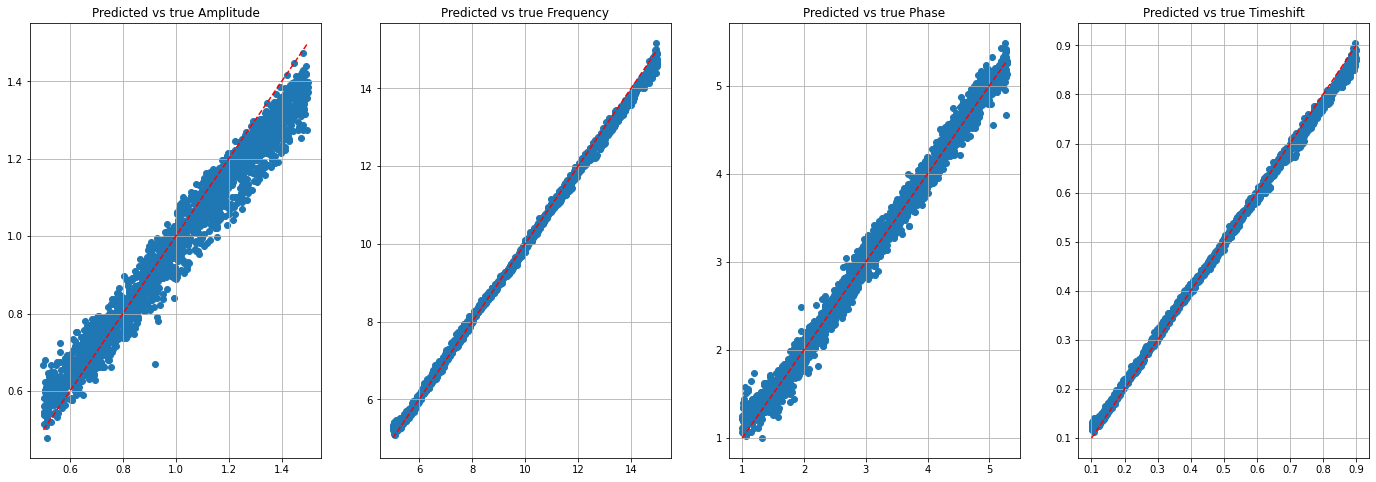

In [39]:
df_y_predict = test_and_predict(model_pulse_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

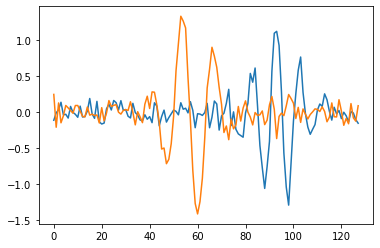

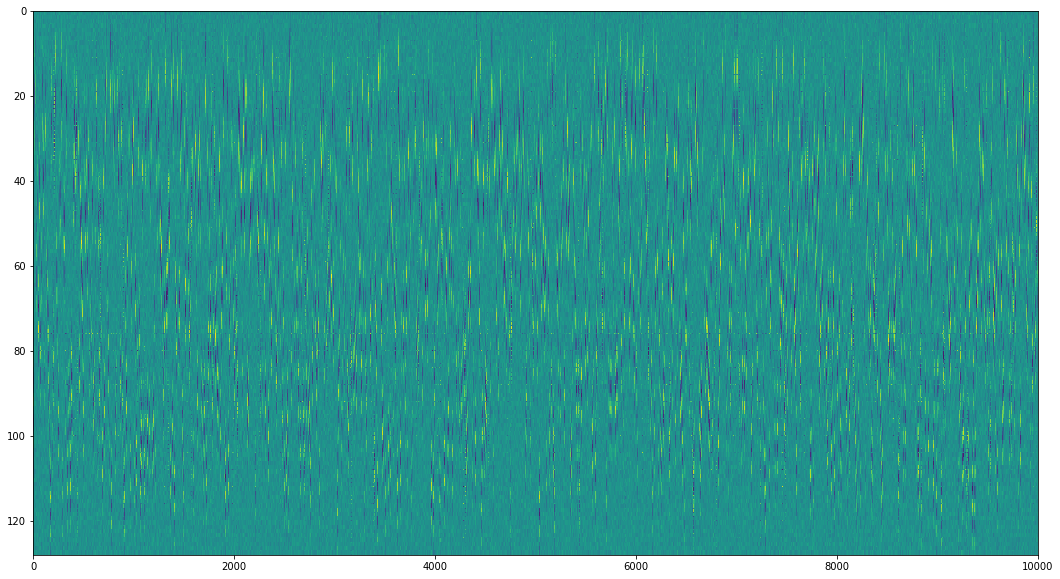

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                

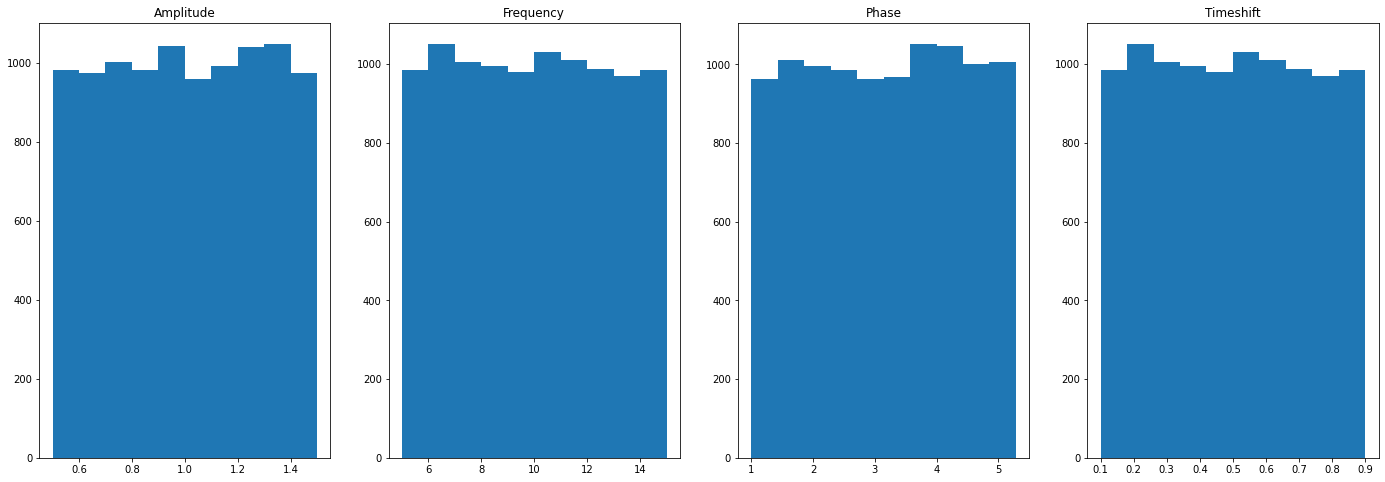

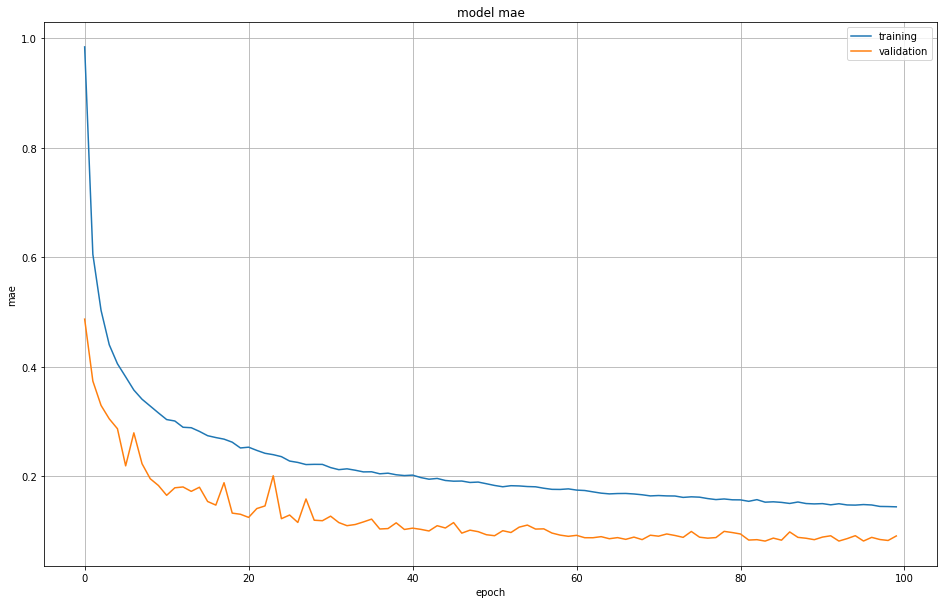

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_timeshift_noisy/assets


In [40]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_timeshift_traces_clean, df_iterations_w_timeshifts, noiseon=True)
model_pulse_timeshift_noisy = getmodel(X_train, y_train, filename=path+'model_pulse_timeshift_noisy', loadmodel=load_models, autoscale=auto_scale)

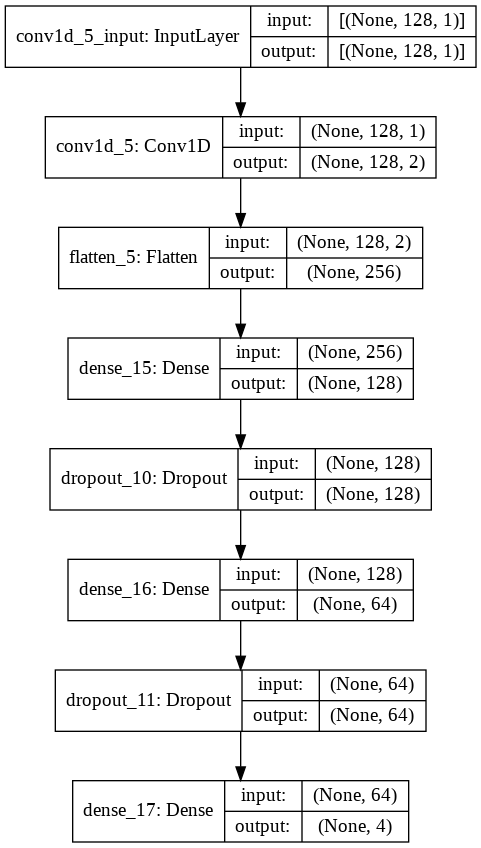

In [41]:
plot_model(model_pulse_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 0.0208 - mse: 0.0208 - mae: 0.0886


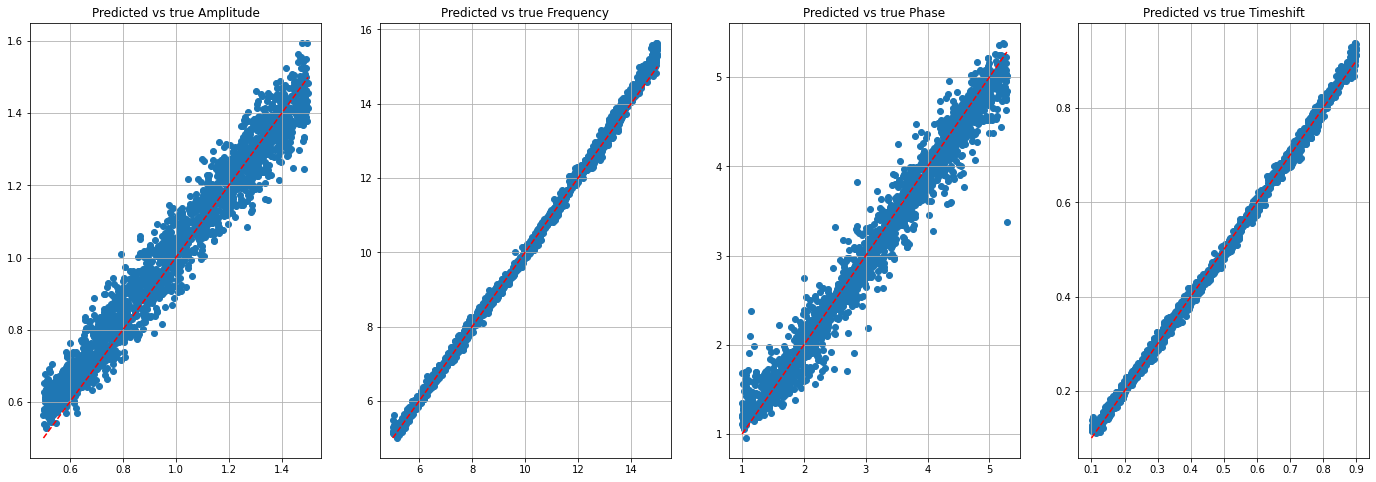

In [42]:
df_y_predict = test_and_predict(model_pulse_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# 2 Pulses with variable timeshift

## Main Section

In [43]:
df_timeshift_1 = makerandomtimeshift(dataset_size, 0.1, 0.4, seed=1)
df_timediff = makerandomtimeshift(dataset_size, 0.1, 0.5, seed=2)
df_timeshift_1.rename(columns={'Timeshift': 'Time1'}, inplace=True)
df_timediff.rename(columns={'Timeshift': 'Timediff'}, inplace=True)
df_2_pulses_timeshift_iterations = df_timeshift_1.join(df_timediff)

In [44]:
timinglist = list((df_2_pulses_timeshift_iterations['Time1'], df_2_pulses_timeshift_iterations['Time1'] + df_2_pulses_timeshift_iterations['Timediff']))
pulse_2_timeshift_traces_clean = [makepulsetimes(row[0], list((row[1], row[2]))) for row in zip(pulse_traces_clean, timinglist[0], timinglist[1])]

In [45]:
df_2_pulses_timeshift_iterations_combined = df_iterations.join(df_2_pulses_timeshift_iterations)

### Clean

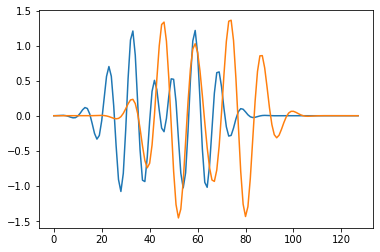

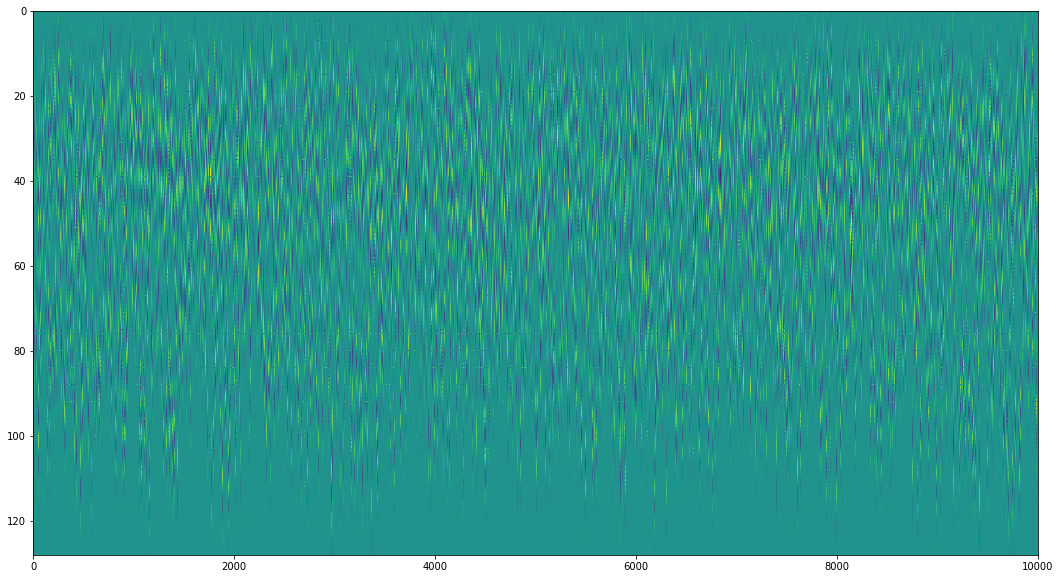

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 5)                

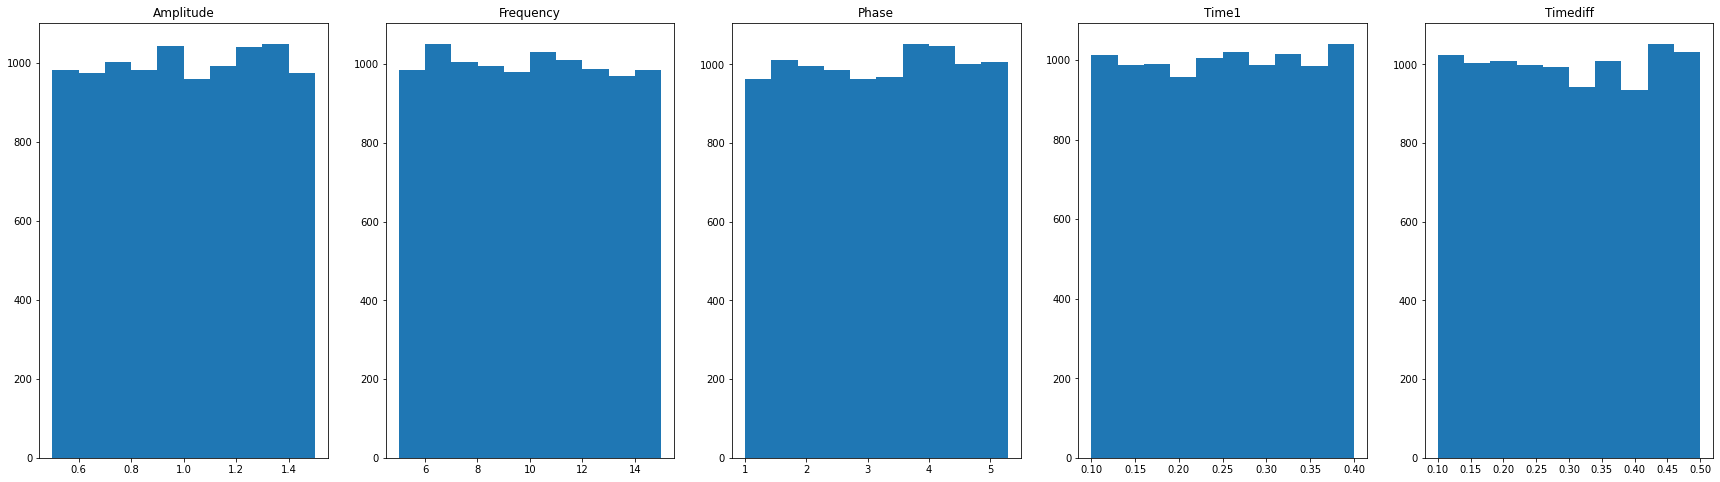

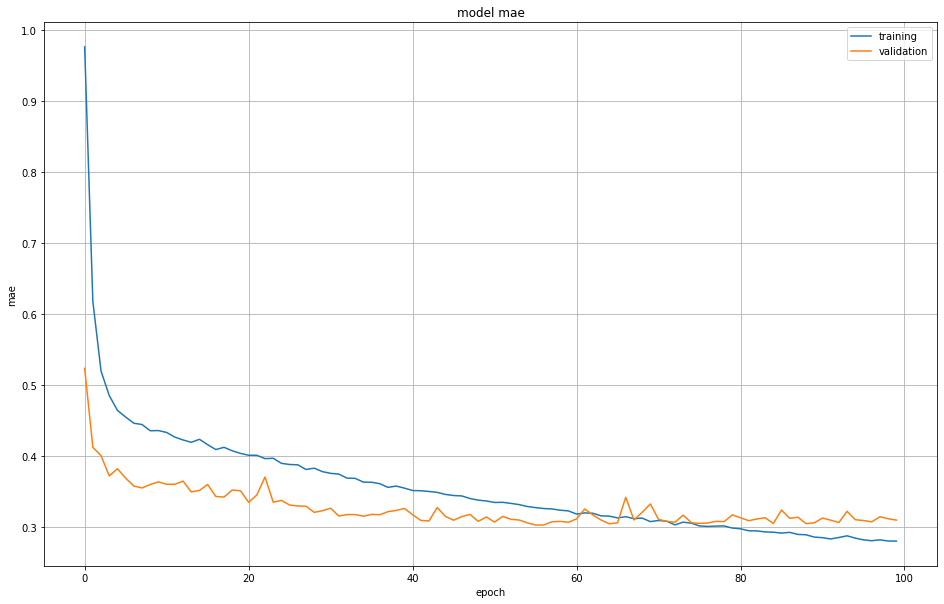

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_2_pulses_timeshift_clean/assets


In [46]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=False)
model_2_pulses_timeshift_clean = getmodel(X_train, y_train, filename=path+'model_2_pulses_timeshift_clean', loadmodel=load_models, autoscale=auto_scale)

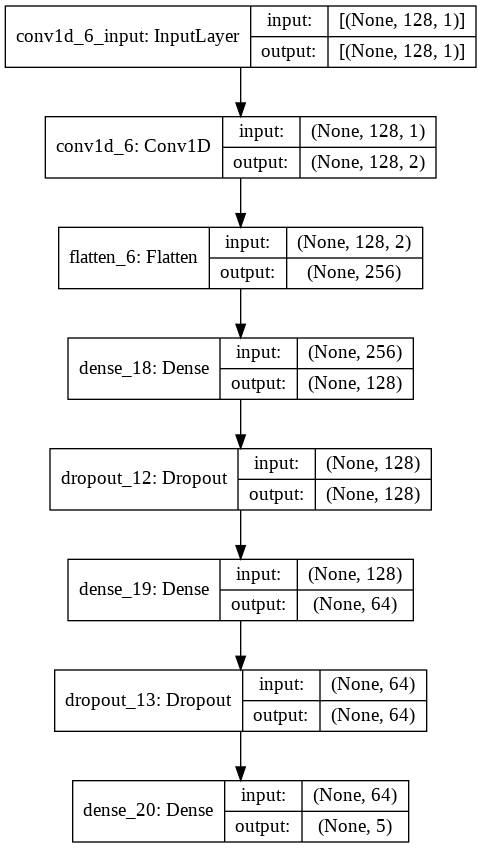

In [47]:
plot_model(model_2_pulses_timeshift_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.3957 - mse: 0.3957 - mae: 0.3078


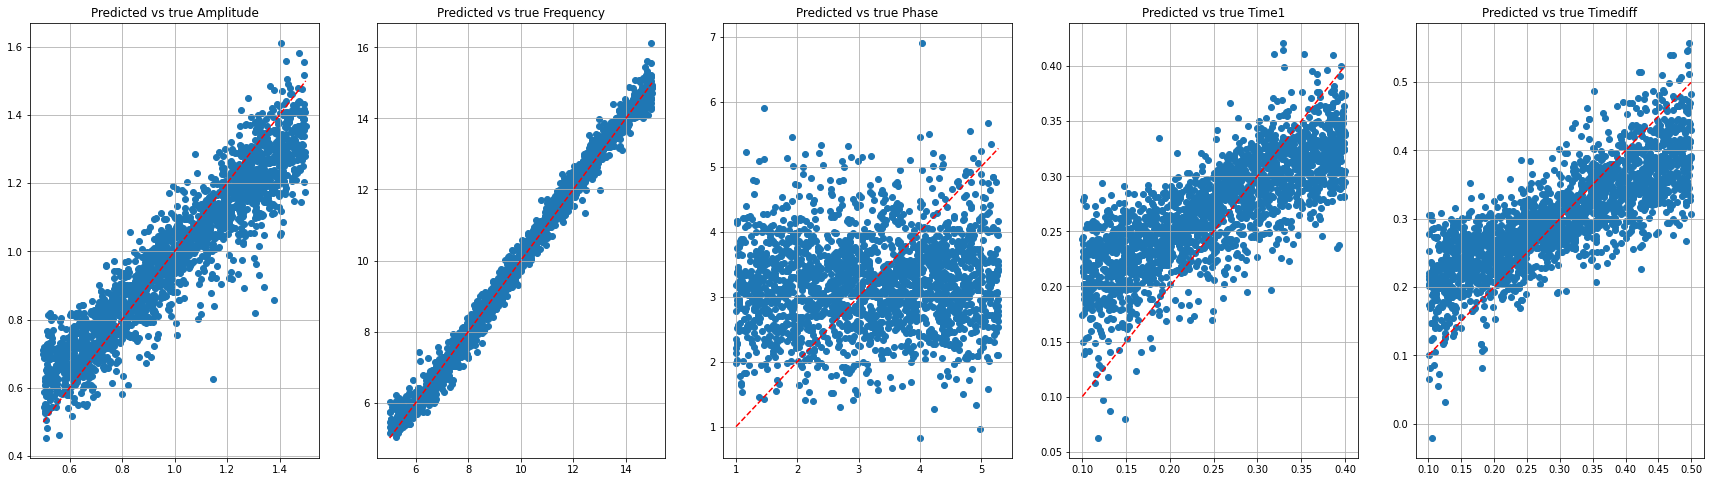

In [48]:
df_y_predict = test_and_predict(model_2_pulses_timeshift_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

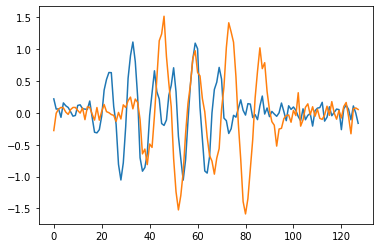

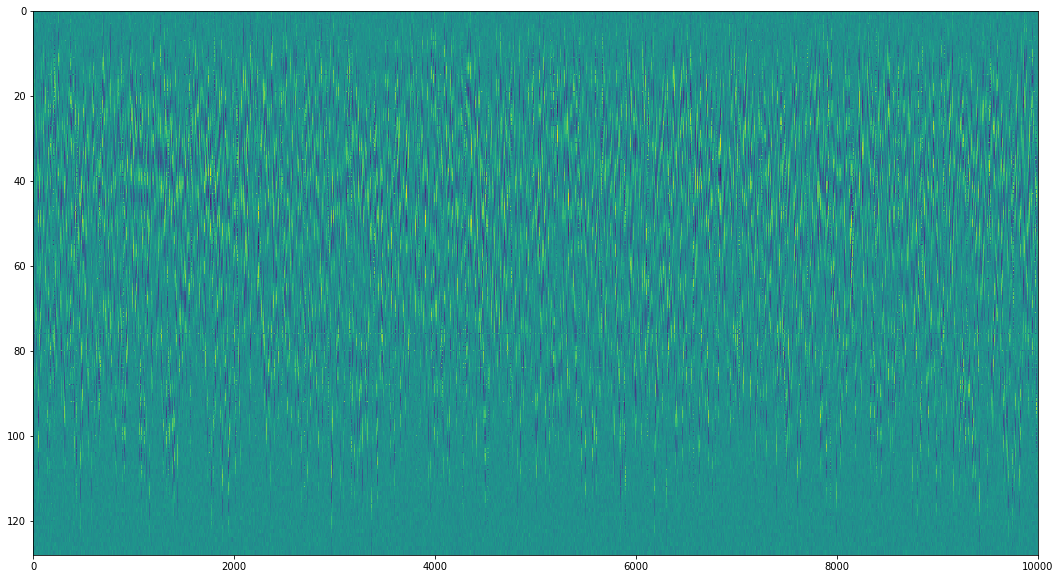

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_7 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 5)                

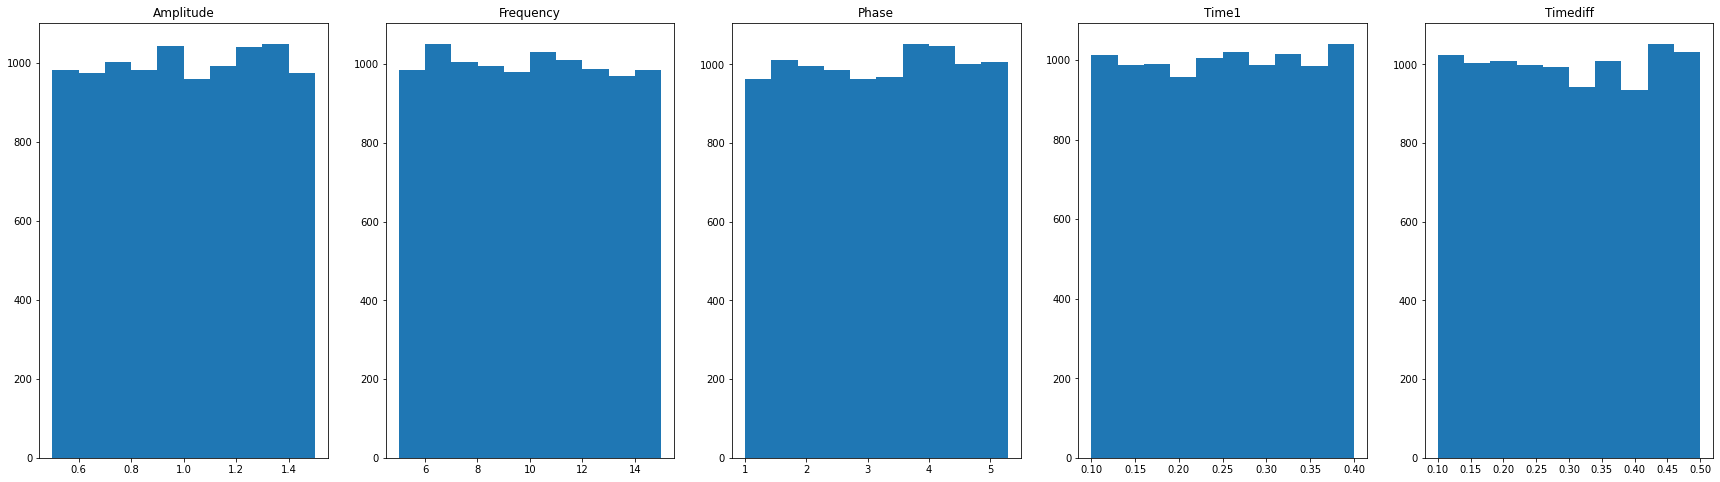

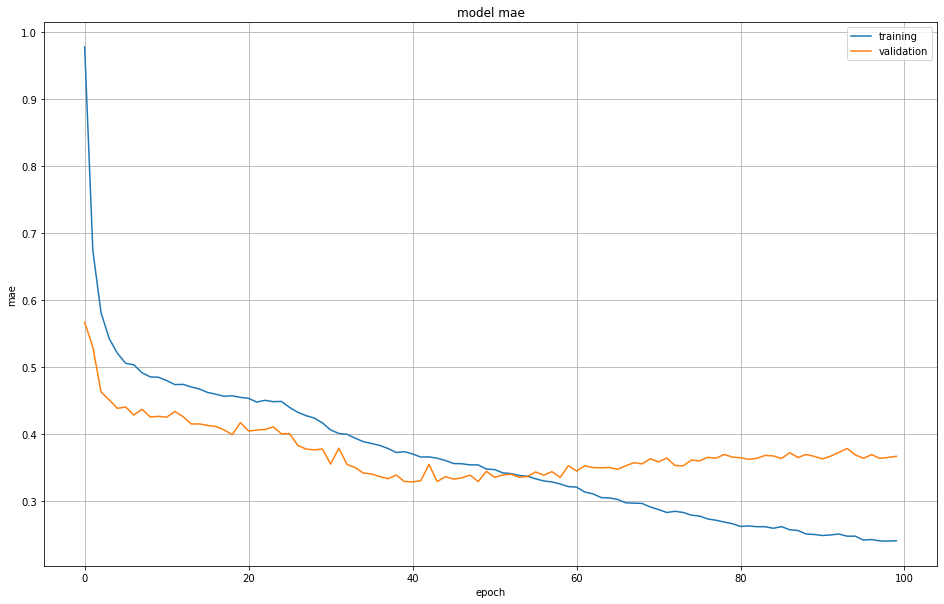

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_2_pulses_timeshift_noisy/assets


In [49]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(pulse_2_timeshift_traces_clean, df_2_pulses_timeshift_iterations_combined, noiseon=True)
model_2_pulses_timeshift_noisy = getmodel(X_train, y_train, filename=path+'model_2_pulses_timeshift_noisy', loadmodel=load_models, autoscale=auto_scale)

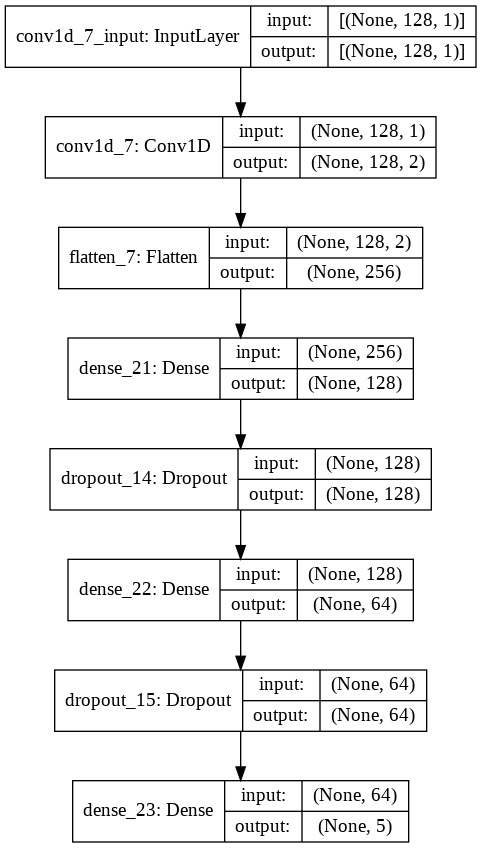

In [50]:
plot_model(model_2_pulses_timeshift_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 0.4770 - mse: 0.4770 - mae: 0.3622


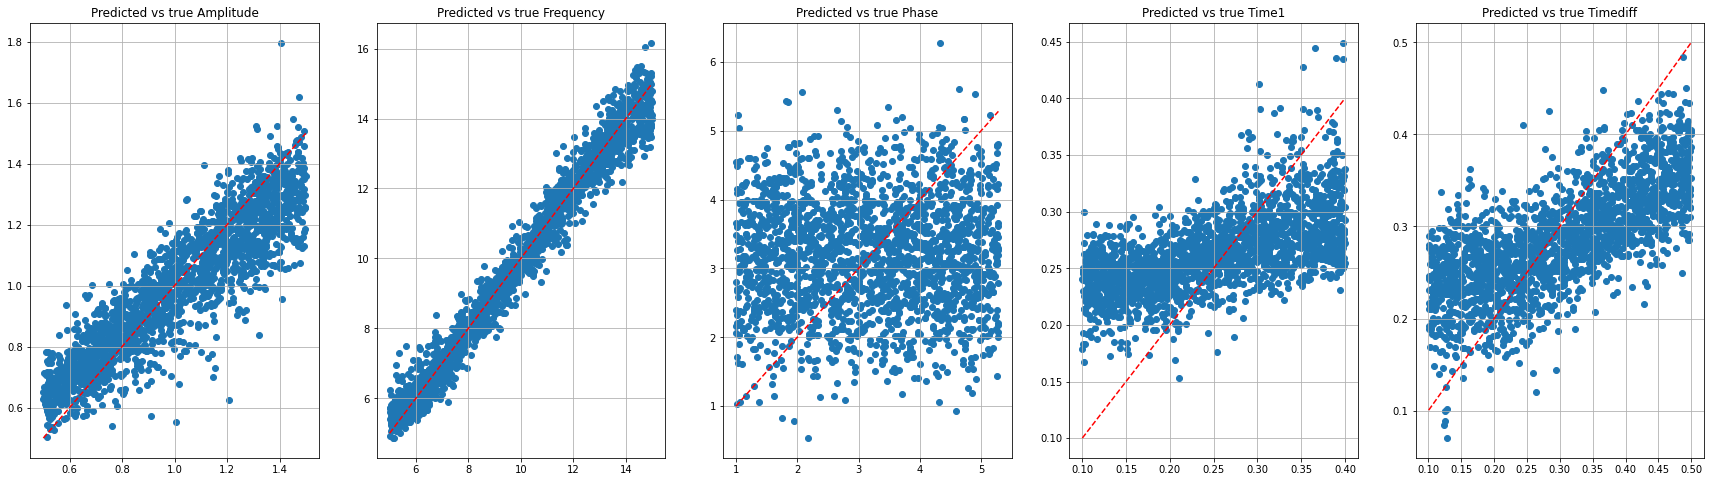

In [51]:
df_y_predict = test_and_predict(model_2_pulses_timeshift_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Interfering CW

## Main Section

In [52]:
df_iterations_cw1 = makerandom(dataset_size, source_central_freq=10, source_mag=1, seed=11)
df_iterations_cw2 = makerandom(dataset_size, source_central_freq=10, source_mag=1, seed=22)
df_iterations_cw1.rename(columns={'Amplitude': 'Amplitude_1', 'Frequency': 'Frequency_1', 'Phase': 'Phase_1'}, inplace=True)
df_iterations_cw2.rename(columns={'Amplitude': 'Amplitude_2', 'Frequency': 'Frequency_2', 'Phase': 'Phase_2'}, inplace=True)
df_iterations_interfering_cw = df_iterations_cw1.join(df_iterations_cw2)

In [53]:
cw1 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw1['Amplitude_1'], df_iterations_cw1['Frequency_1'], df_iterations_cw1['Phase_1'])]
cw2 = [makecwsignal(row[0], row[1], row[2]) for row in zip(df_iterations_cw2['Amplitude_2'], df_iterations_cw2['Frequency_2'], df_iterations_cw2['Phase_2'])]


In [54]:
cw1_plus_cw2_clean = [row[0] + row[1] for row in zip(cw1, cw2)]

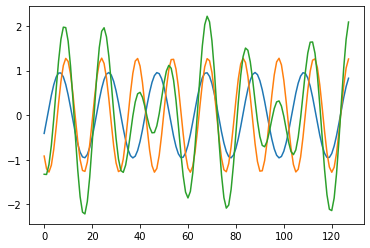

In [55]:
plt.plot(cw1[0])
plt.plot(cw2[0])
plt.plot(cw1_plus_cw2_clean[0])
plt.show()

### Clean

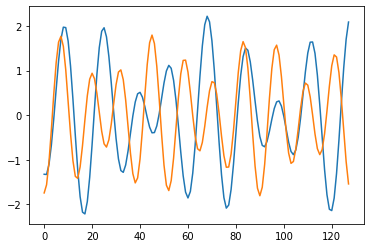

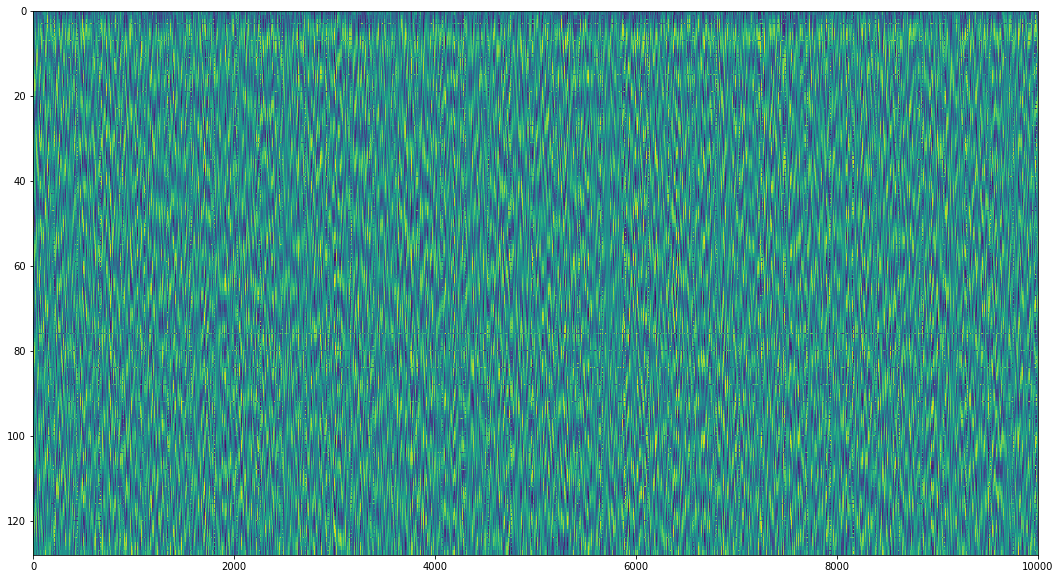

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_8 (Conv1D)            (None, 128, 2)            66        
_________________________________________________________________
flatten_8 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 6)                

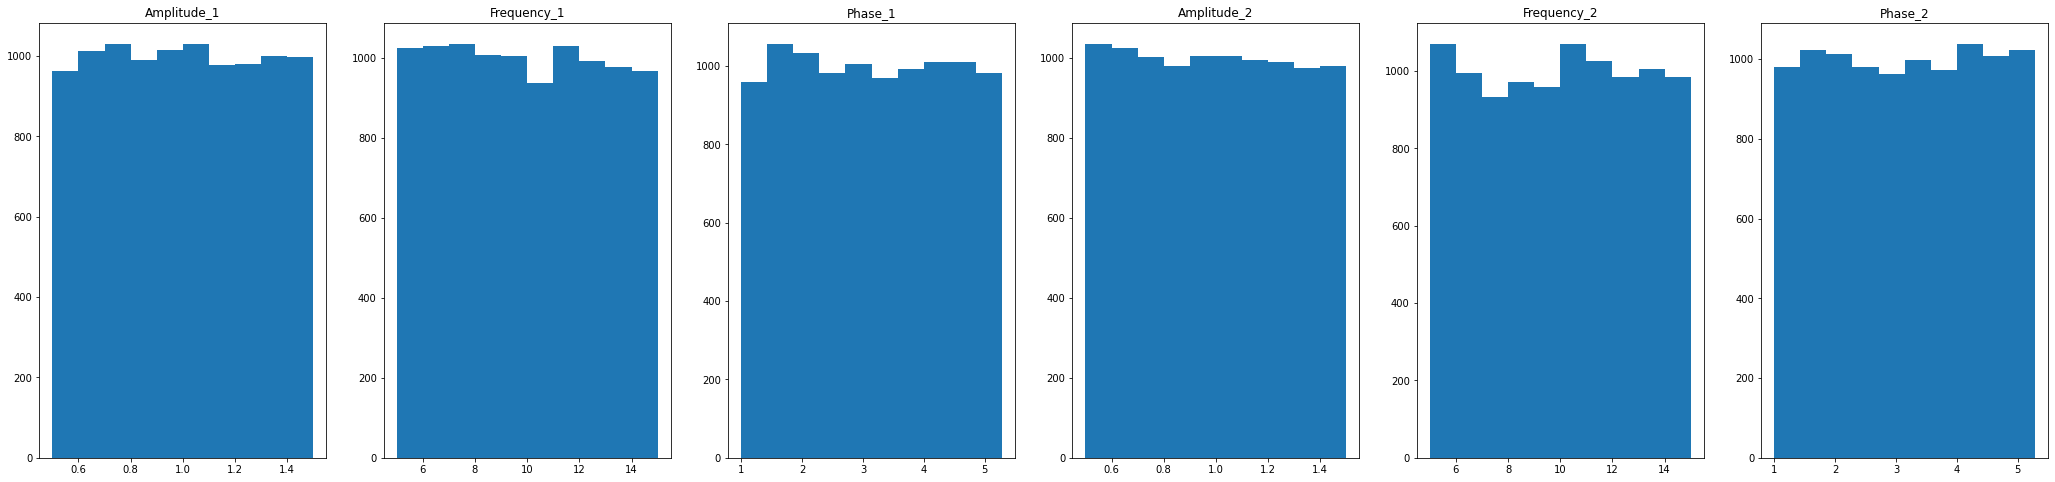

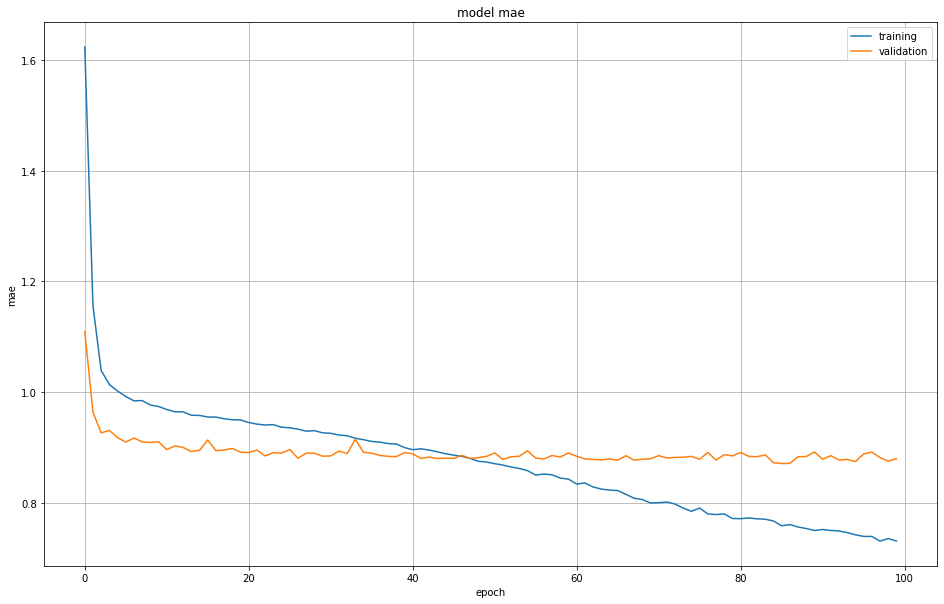

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_interfering_cw_clean/assets


In [56]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw, noiseon=False)
model_interfering_cw_clean = getmodel(X_train, y_train, filename=path+'model_interfering_cw_clean', loadmodel=False, autoscale=auto_scale)

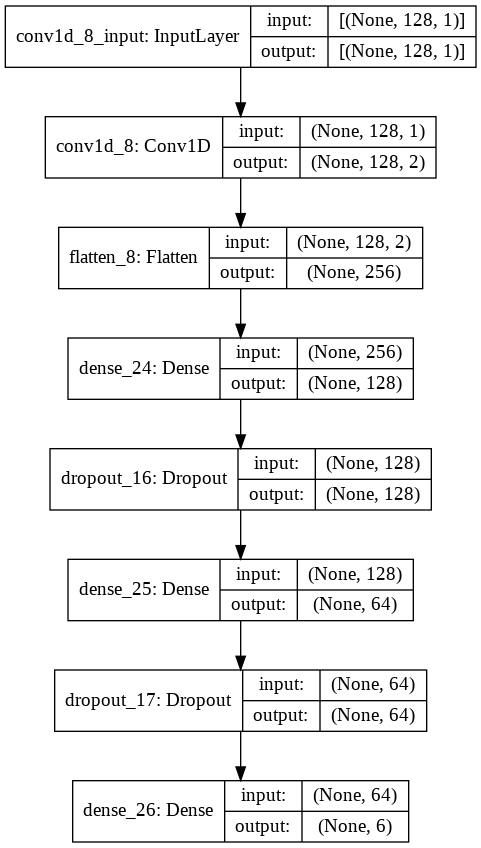

In [57]:
plot_model(model_interfering_cw_clean, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 2.3030 - mse: 2.3030 - mae: 0.9343


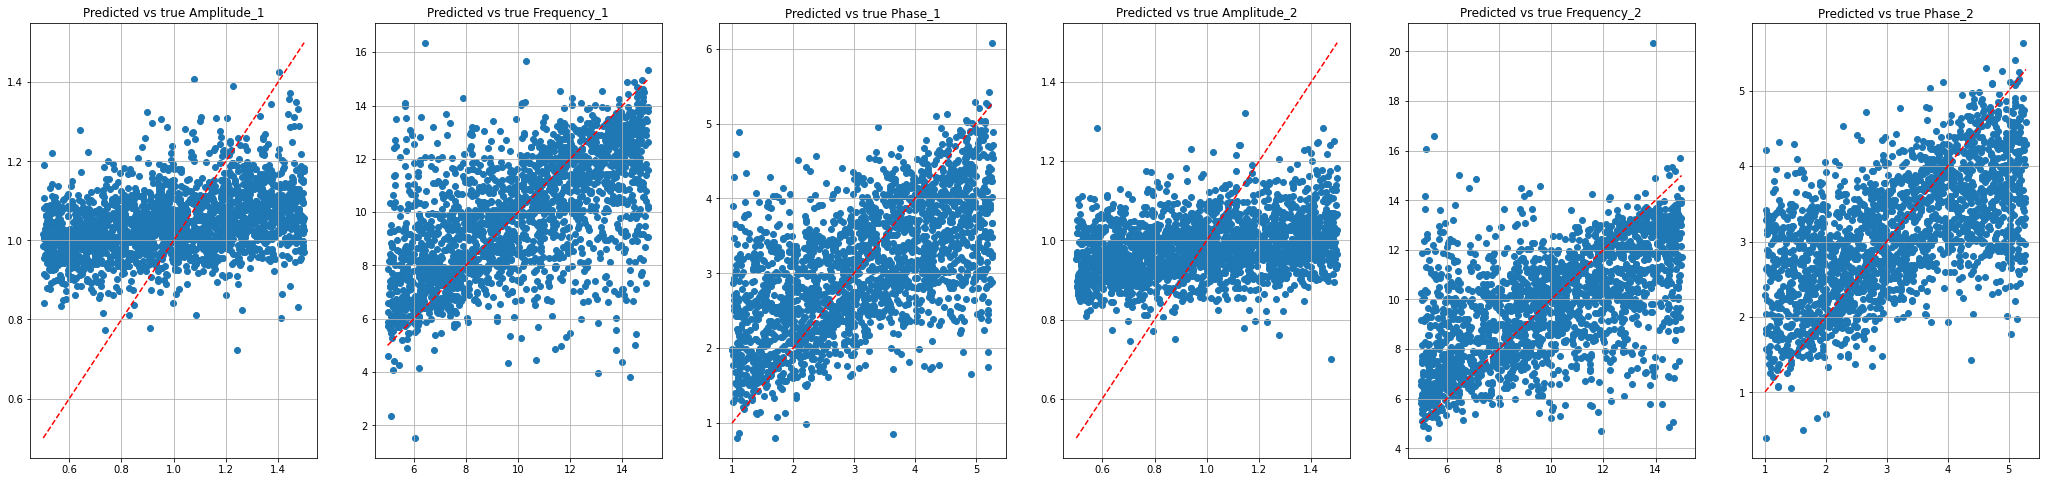

In [58]:
df_y_predict = test_and_predict(model_interfering_cw_clean, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Noisy

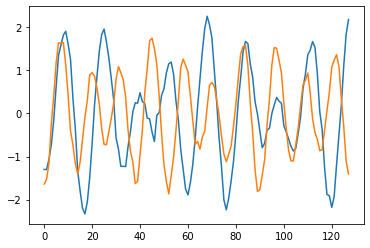

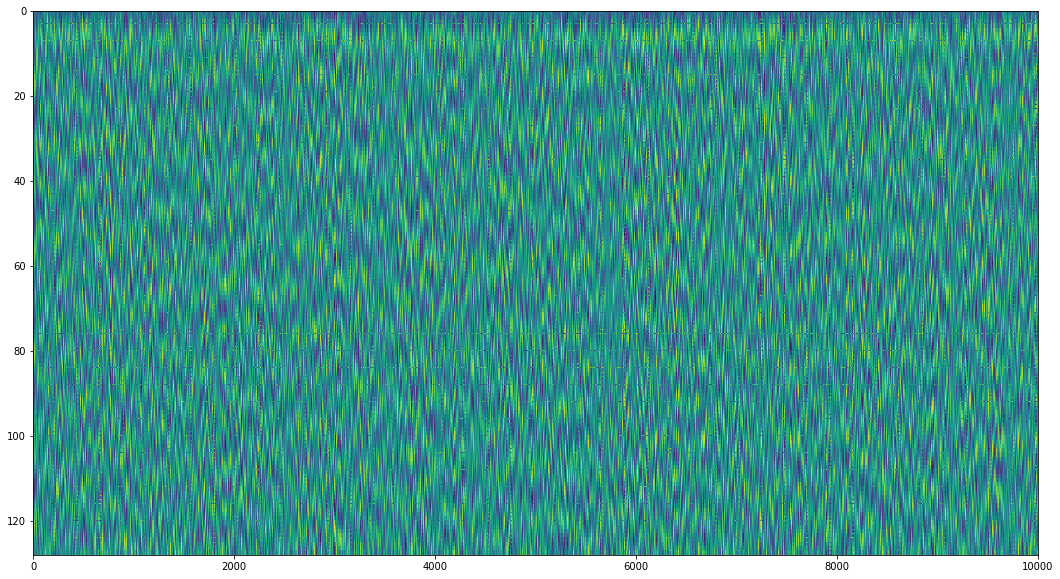

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 128, 6)            198       
_________________________________________________________________
flatten_9 (Flatten)          (None, 768)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 128)               98432     
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 6)                

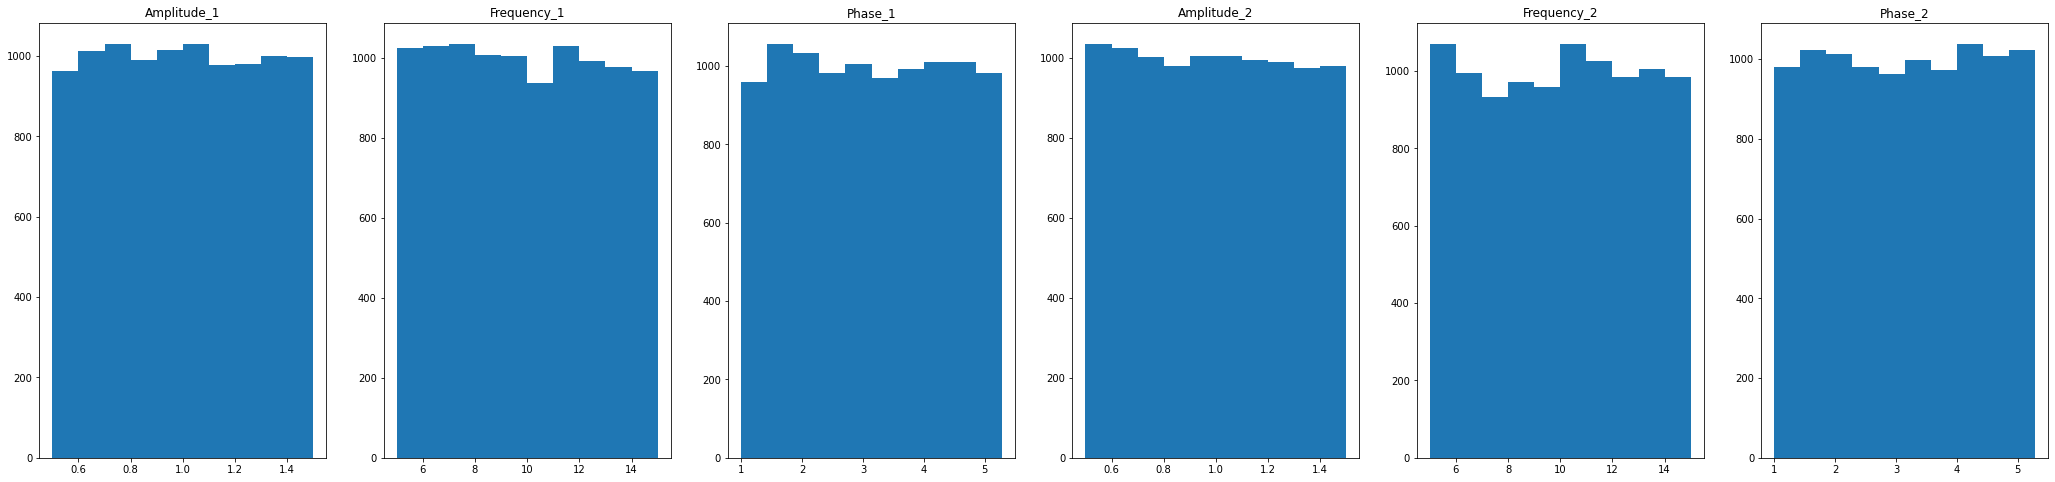

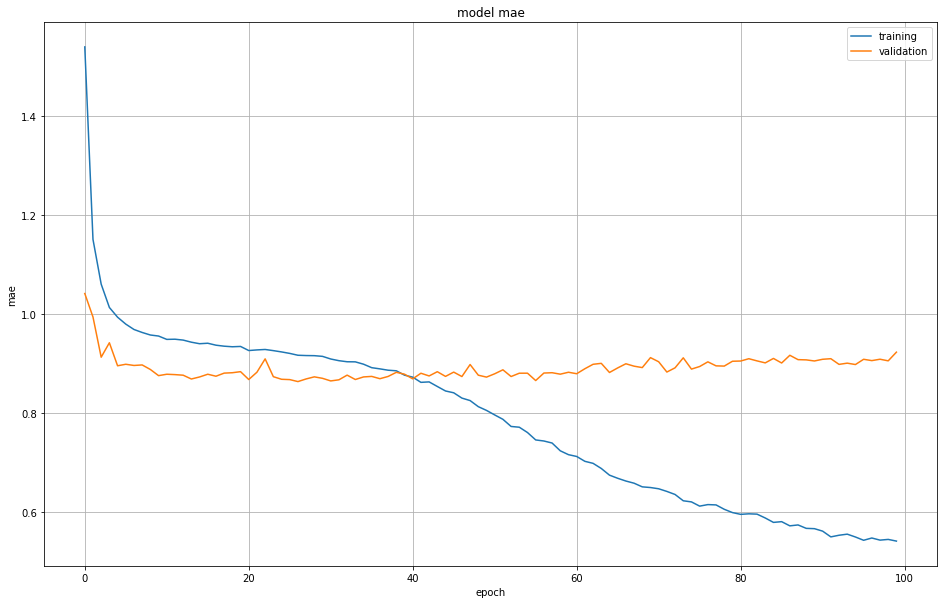

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_interfering_cw_clean/assets


In [59]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots(cw1_plus_cw2_clean, df_iterations_interfering_cw, noiseon=True)
model_interfering_cw_noisy = getmodel(X_train, y_train, filename=path+'model_interfering_cw_clean', loadmodel=load_models)

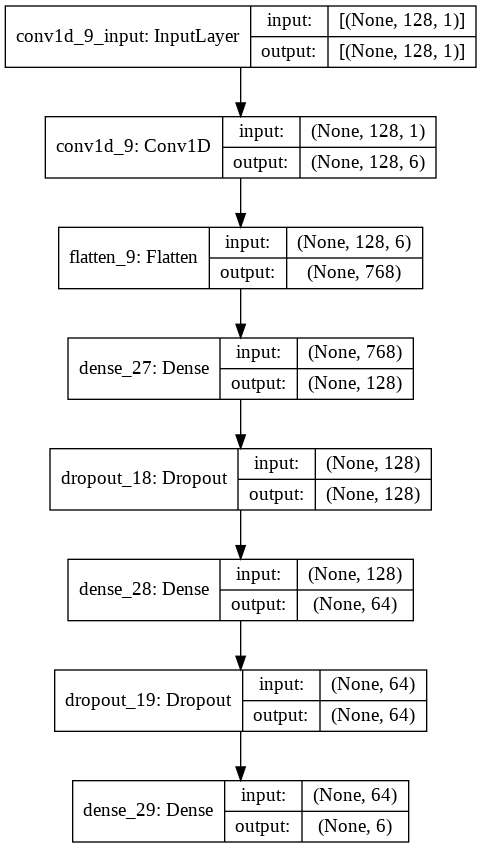

In [60]:
plot_model(model_interfering_cw_noisy, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 2.5330 - mse: 2.5330 - mae: 0.9443


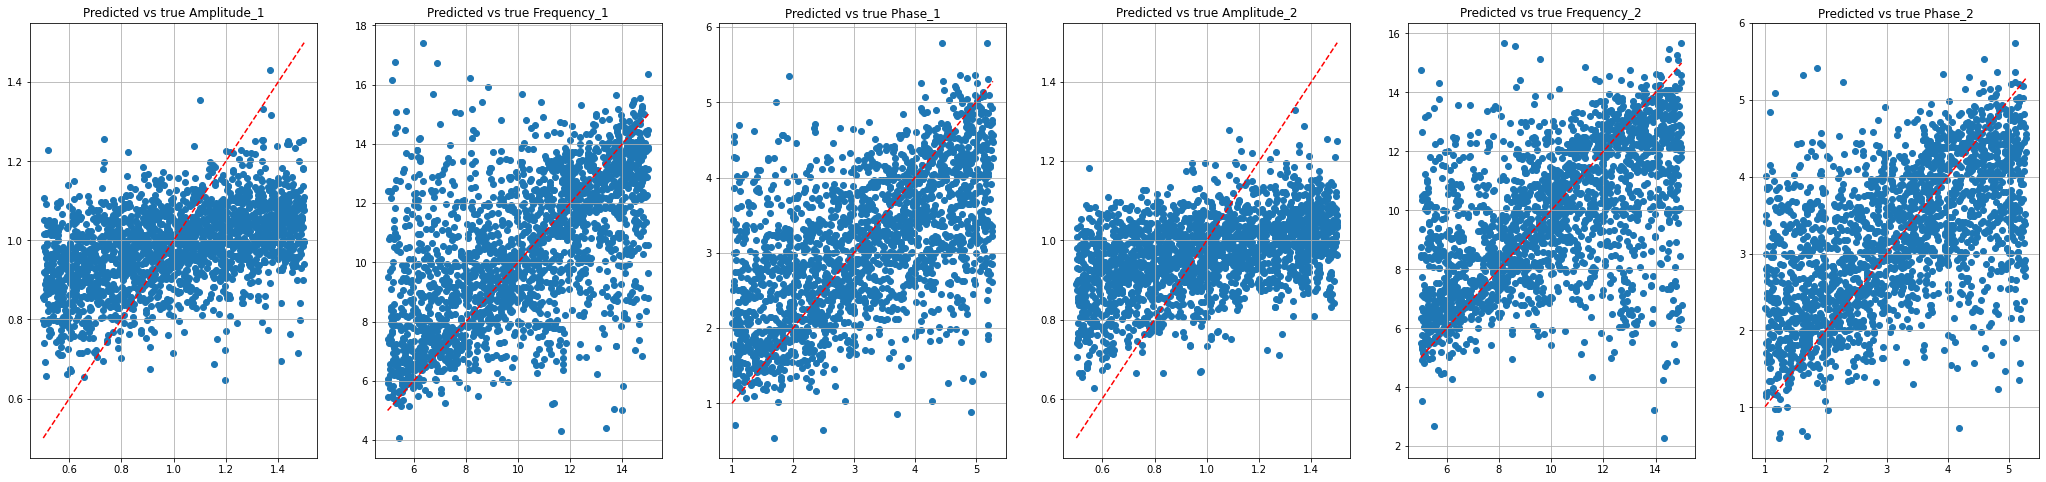

In [61]:
df_y_predict = test_and_predict(model_interfering_cw_noisy, X_test, y_test)
plotprediction(y_test, df_y_predict)

# Pre-Processing

## Helper functions

In [62]:
from scipy.signal import hilbert, correlate

In [63]:
def autocorr(array_in):
  no_traces = len(array_in)
  result = np.zeros_like(array_in)
  for i in range(0, no_traces):
    temp = np.correlate(array_in[i], array_in[i], mode='full')
    result[i] = temp[temp.size//2:]
  return result

In [64]:
def hilbert_autocorr(traces):
  traces_hilbert = abs(hilbert(traces))
  traces_autocorr = autocorr(traces)
  traces_hilbert_autocorr = autocorr(traces_hilbert)
  return np.stack((traces, traces_hilbert, traces_autocorr, traces_hilbert_autocorr), axis=-1)

In [65]:
def preprocessing_split_and_plots_2(traces_clean, df_iterations, noiseon=False, noiselevel=0.1):
  if noiseon:
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
  else:
    traces = traces_clean
  #df_traces = pd.DataFrame(traces)
  plt.plot(traces[0,:,0])
  plt.plot(traces[1,:,0])
  plt.show()
  plt.figure(figsize=(18, 10))
  #plt.pcolormesh(df_traces.T)
  #plt.gca().invert_yaxis()
  #plt.show()

  plot_hists(df_iterations)

  X_train, X_test, y_train, y_test = train_test_split(traces, df_iterations, test_size=0.2, random_state=42)
  #X_train = np.expand_dims(X_train, axis=2)
  print(X_train.shape, y_train.shape)
  return X_train, X_test, y_train, y_test

## Envelope Detection and Autocorrelation

Datasets:



1.   traces_clean - Probably no benefit since CW (envelope or autocorr has no meaning)
2.   pulse_traces_clean
3.   pulse_timeshift_traces_clean
4.   pulse_2_timeshift_traces_clean
5.   model_interfering_cw_clean






### Continous Wave

In [66]:
traces_clean_hilbert_autocorr = hilbert_autocorr(traces_clean)

In [ ]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(traces_clean_hilbert_autocorr, df_iterations, noiseon=False)
model_cw_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+'model_cw_clean_hilbert_autocorr', loadmodel=load_models, autoscale=auto_scale)

In [ ]:
plot_model(model_cw_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0198 - mse: 0.0198 - mae: 0.1060


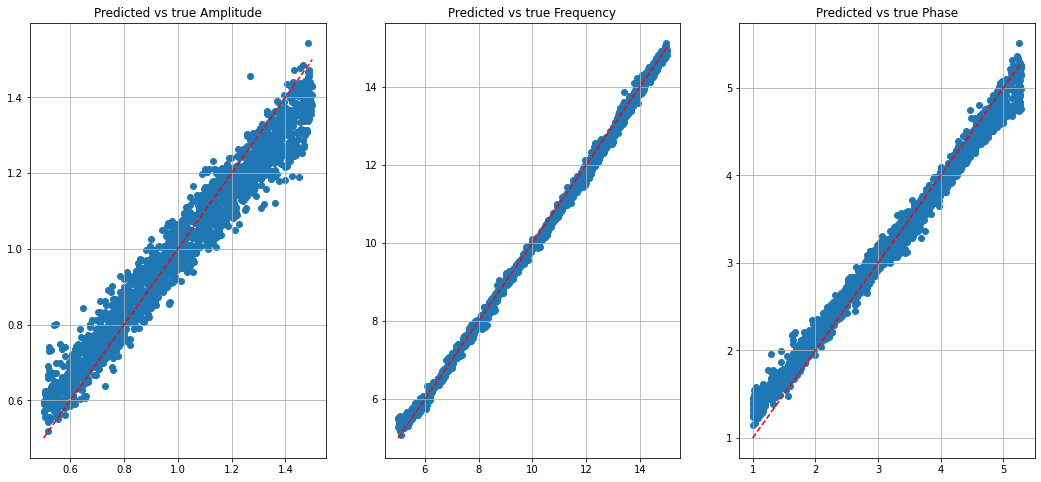

In [70]:
df_y_predict = test_and_predict(model_cw_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Signal Pulse

In [72]:
pulse_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_traces_clean)

In [ ]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_clean_hilbert_autocorr, df_iterations, noiseon=False)
model_pulse_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+'model_pulse_clean_hilbert_autocorr', loadmodel=False, autoscale=auto_scale)

In [ ]:
plot_model(model_pulse_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 0.0080 - mse: 0.0080 - mae: 0.0652


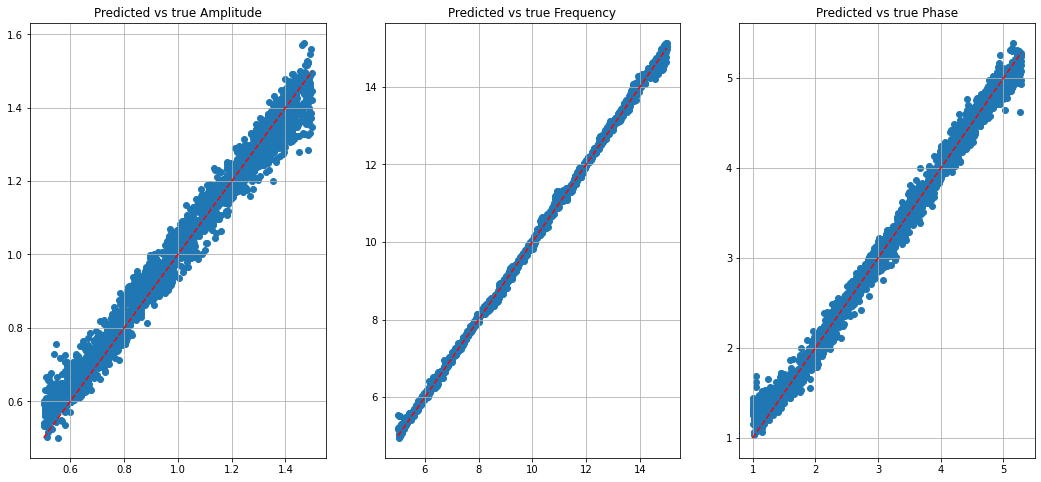

In [75]:
df_y_predict = test_and_predict(model_pulse_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

In [77]:
def add_noise(traces_clean, noiselevel=0.1):
    traces = [trace + np.random.normal(0, noiselevel, size=len(trace)) for trace in traces_clean]
    return traces

In [78]:
pulse_traces_noisy = add_noise(pulse_traces_clean)

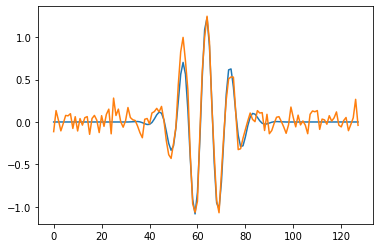

In [80]:
plt.plot(pulse_traces_clean[0])
plt.plot(pulse_traces_noisy[0])
plt.show()

In [99]:
pulse_traces_noisy_hilbert_autocorr = hilbert_autocorr(pulse_traces_noisy)

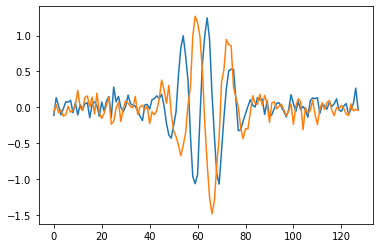

(8000, 128, 4) (8000, 3)
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_14 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_14 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_28 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_29 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_44 (Dense)            

<Figure size 1296x720 with 0 Axes>

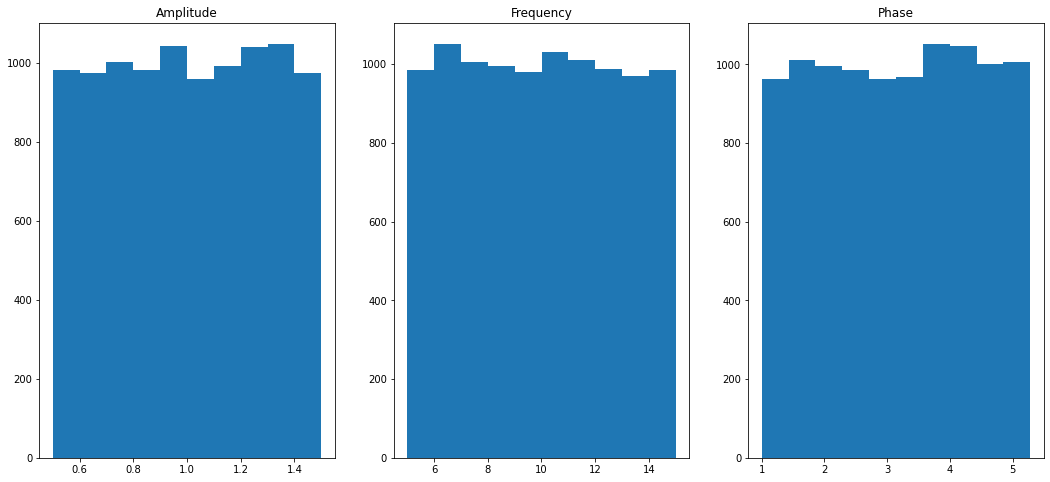

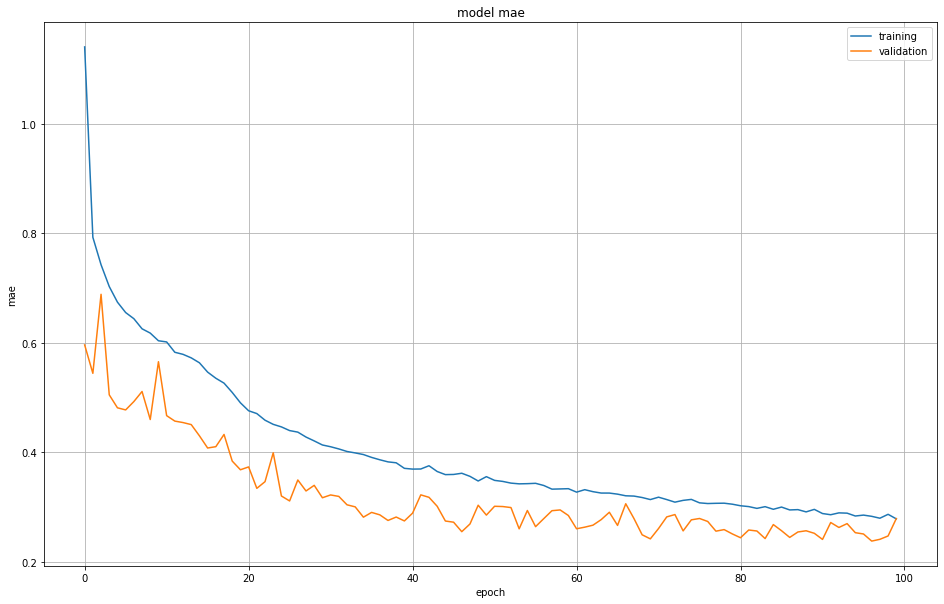

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_noisy_hilbert_autocorr/assets


In [100]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_traces_noisy_hilbert_autocorr, df_iterations, noiseon=False) # noiseon=False since noise is alreay added.
model_pulse_noisy_hilbert_autocorr = getmodel(X_train, y_train, filename=path+'model_pulse_noisy_hilbert_autocorr', loadmodel=load_models, autoscale=auto_scale)

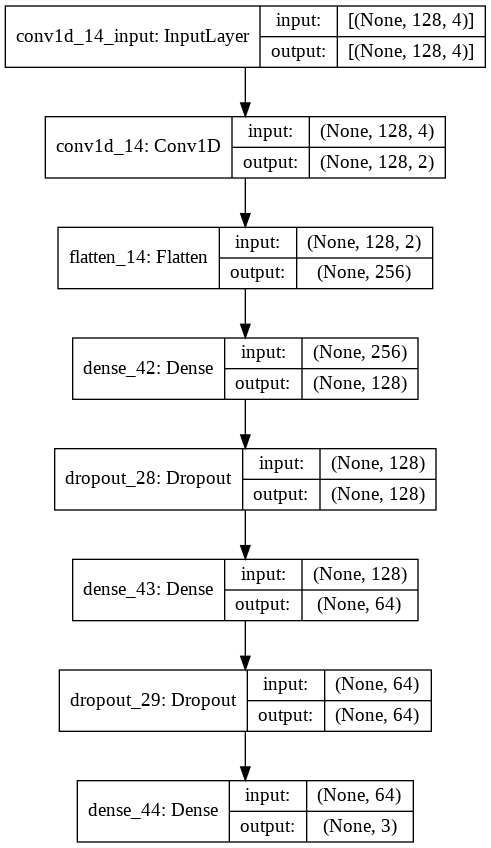

In [101]:
plot_model(model_pulse_noisy_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 4ms/step - loss: 0.1728 - mse: 0.1728 - mae: 0.2713


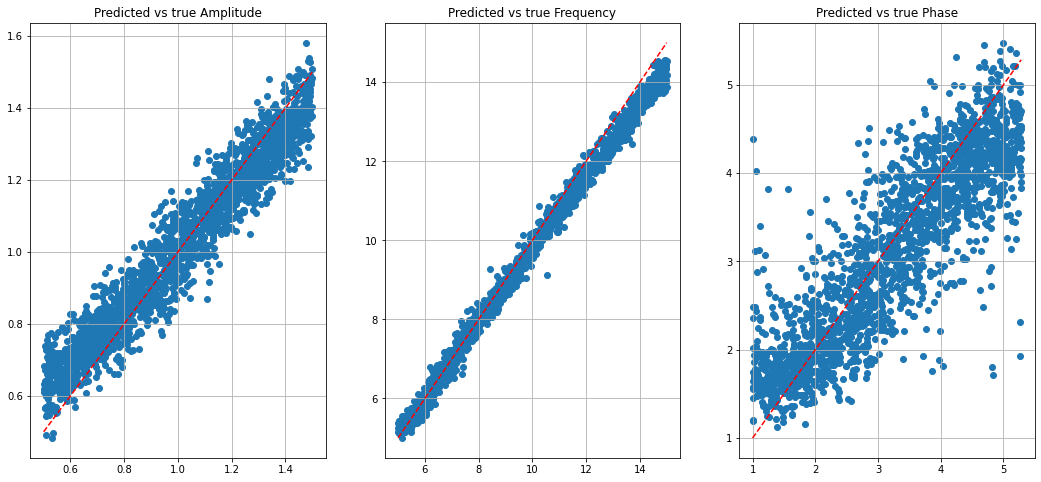

In [102]:
df_y_predict = test_and_predict(model_pulse_noisy_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

### Pulse with Timeshift

In [103]:
pulse_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_timeshift_traces_clean)

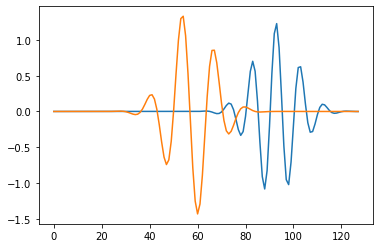

(8000, 128, 4) (8000, 4)
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 128, 2)            258       
_________________________________________________________________
flatten_15 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_45 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_30 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_31 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_47 (Dense)            

<Figure size 1296x720 with 0 Axes>

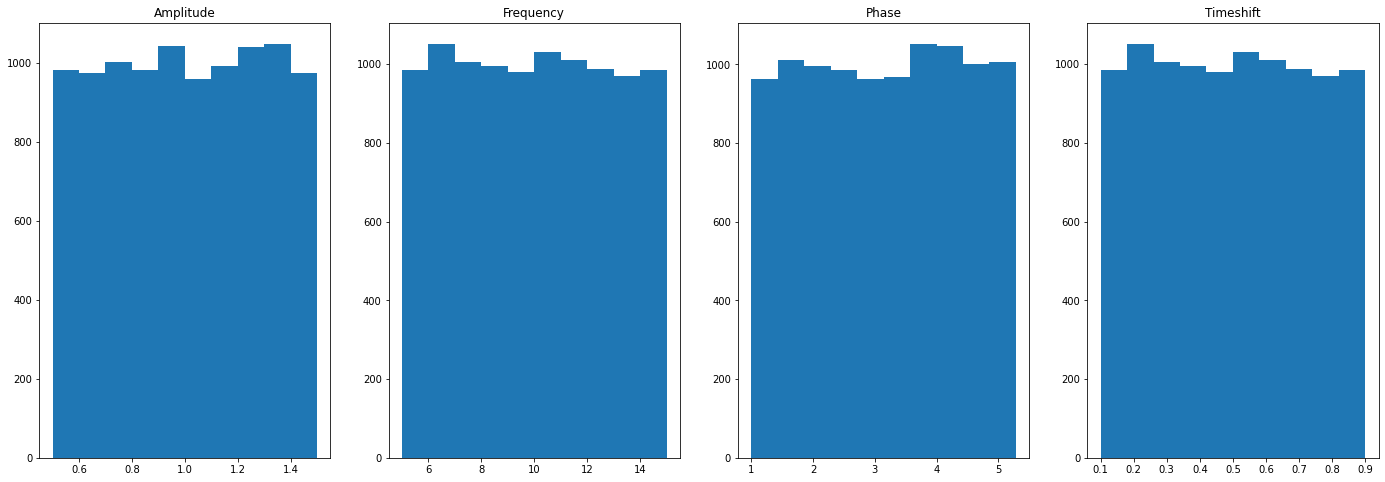

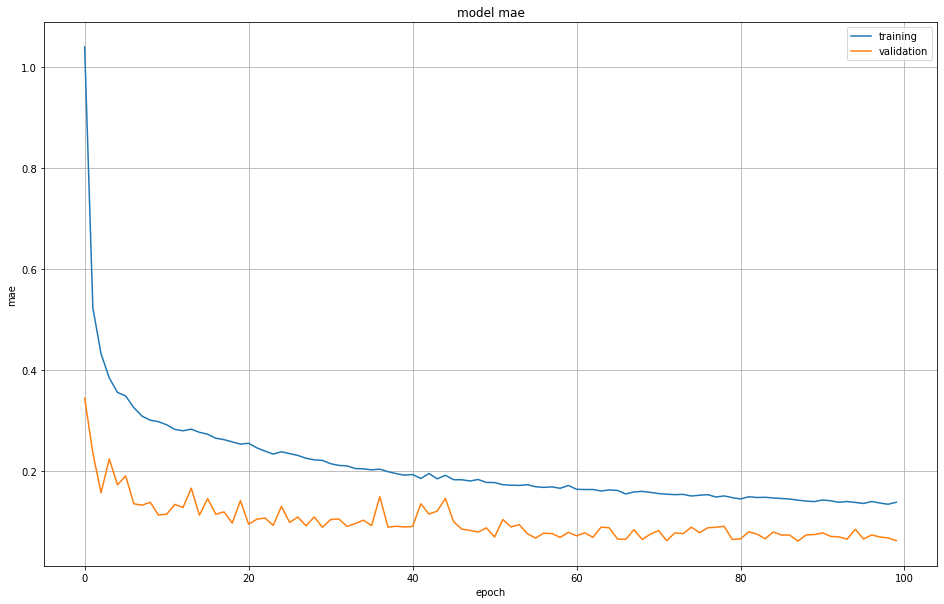

INFO:tensorflow:Assets written to: /gdrive/My Drive/Colab Notebooks/PhD/17_Article/Models/model_pulse_timeshift_clean_hilbert_autocorr/assets


In [104]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_timeshift_traces_clean_hilbert_autocorr, df_iterations_w_timeshifts, noiseon=False)
model_pulse_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+'model_pulse_timeshift_clean_hilbert_autocorr', loadmodel=load_models, autoscale=auto_scale)

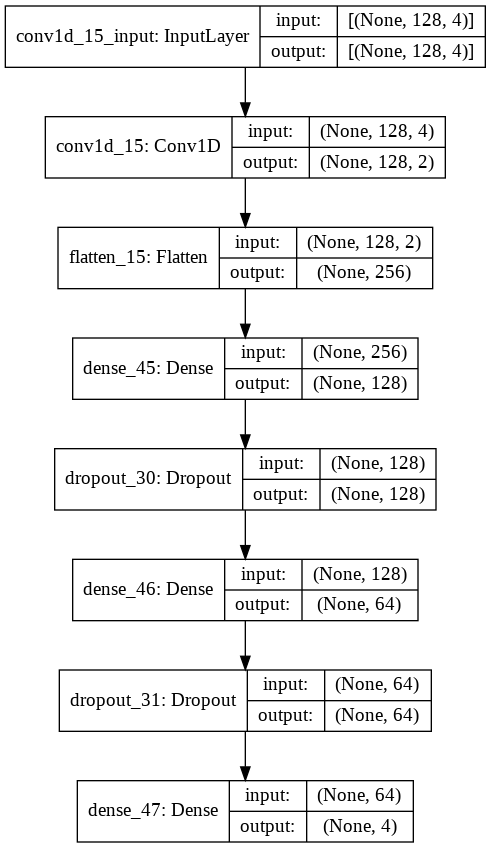

In [105]:
plot_model(model_pulse_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.0084 - mse: 0.0084 - mae: 0.0639


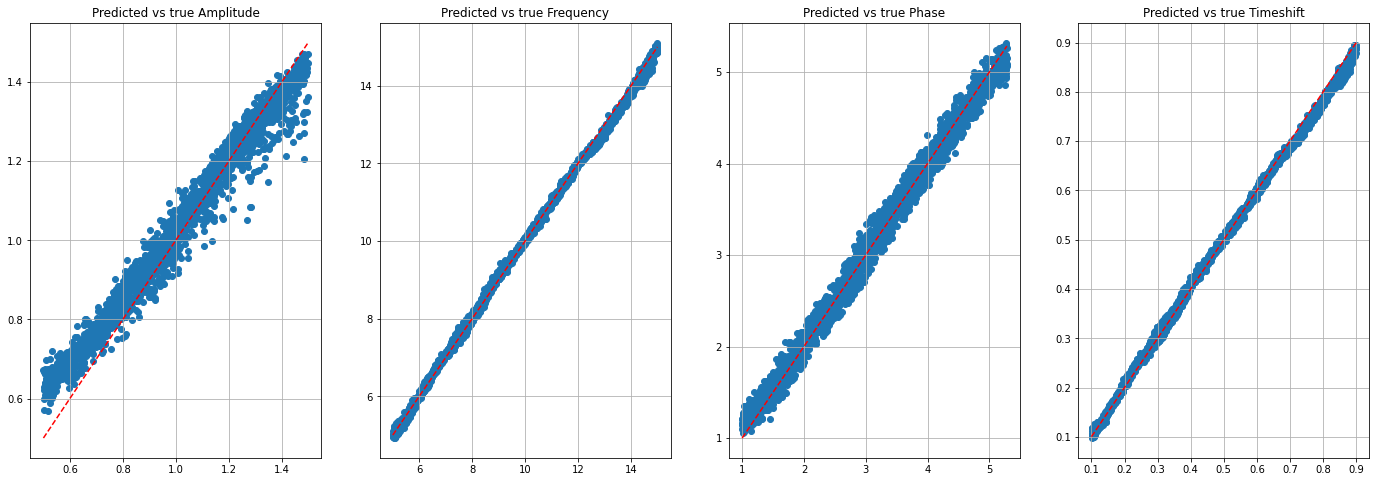

In [106]:
df_y_predict = test_and_predict(model_pulse_timeshift_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)

### 2 Pulses with variable timeshift

In [111]:
pulse_2_timeshift_traces_clean_hilbert_autocorr = hilbert_autocorr(pulse_2_timeshift_traces_clean)

In [112]:
pulse_2_timeshift_traces_clean_hilbert_autocorr.shape

(10000, 128, 4)

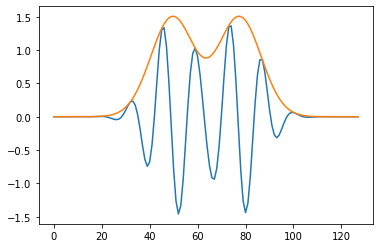

In [113]:
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,0])
plt.plot(pulse_2_timeshift_traces_clean_hilbert_autocorr[1,:,1])

In [ ]:
X_train, X_test, y_train, y_test = preprocessing_split_and_plots_2(pulse_2_timeshift_traces_clean_hilbert_autocorr, df_2_pulses_timeshift_iterations_combined, noiseon=False)
model_2_pulses_timeshift_clean_hilbert_autocorr = getmodel(X_train, y_train, filename=path+'model_2_pulses_timeshift_clean_hilbert_autocorr', loadmodel=load_models, autoscale=auto_scale)

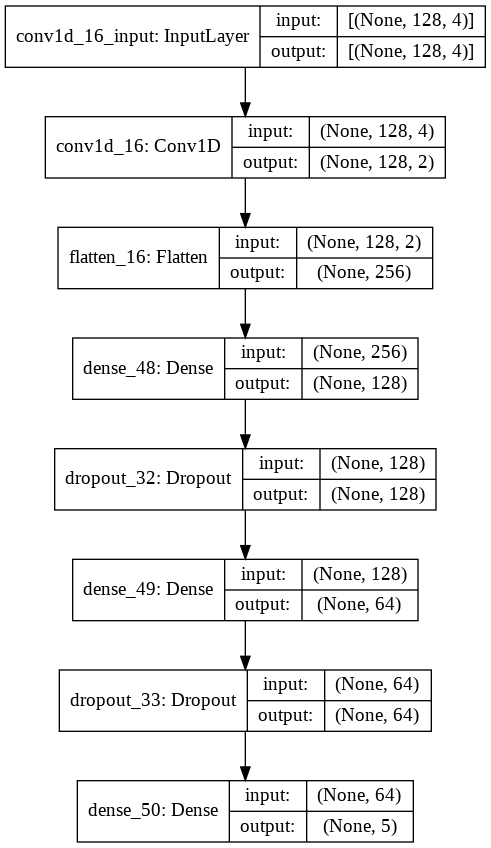

In [116]:
plot_model(model_2_pulses_timeshift_clean_hilbert_autocorr, show_shapes=True, show_layer_names=True)

63/63 [==============================] - 1s 3ms/step - loss: 0.3369 - mse: 0.3369 - mae: 0.3013


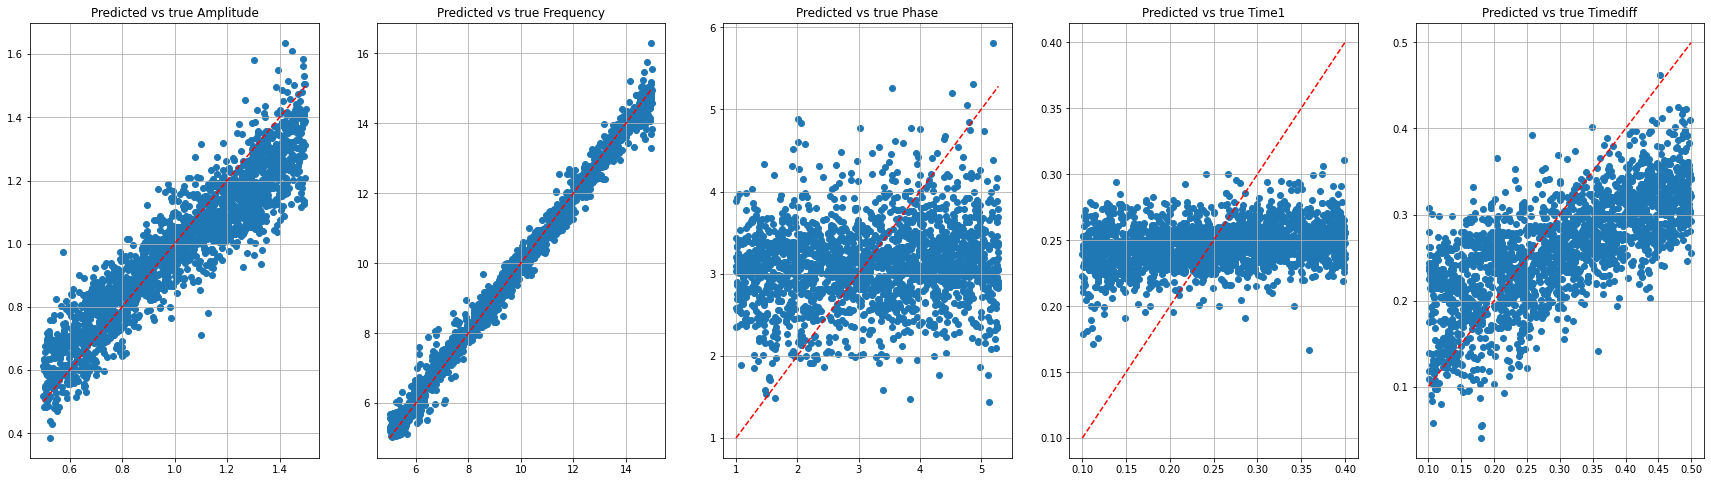

In [115]:
df_y_predict = test_and_predict(model_2_pulses_timeshift_clean_hilbert_autocorr, X_test, y_test)
plotprediction(y_test, df_y_predict)